# Bifurcation data analysis

In this notebook, let's create a workflow to process images from the **bifurcation** experiment. This will involve 3 steps:

- crop channel regions from raw images
- apply PIV on cropped images
- compute relevant numbers, e.g. flow rates in each channel, from PIV data 

## 1 Crop channel regions from raw images

In a typical bifurcation experiment, we have a 3-way micro-channel photoprinted on a resin. This micro-channel is cast on the active microtubule system at an oil-water interface. The chaotic turbulent-like motions of microtubules will be rectified by the micro-channels. Ratchet structures are used to set one of the channels as inlet. The flow then goes into either remaining channels, or into both at certain fractions. We study what is the "preferred" bifurcation of the flow. 

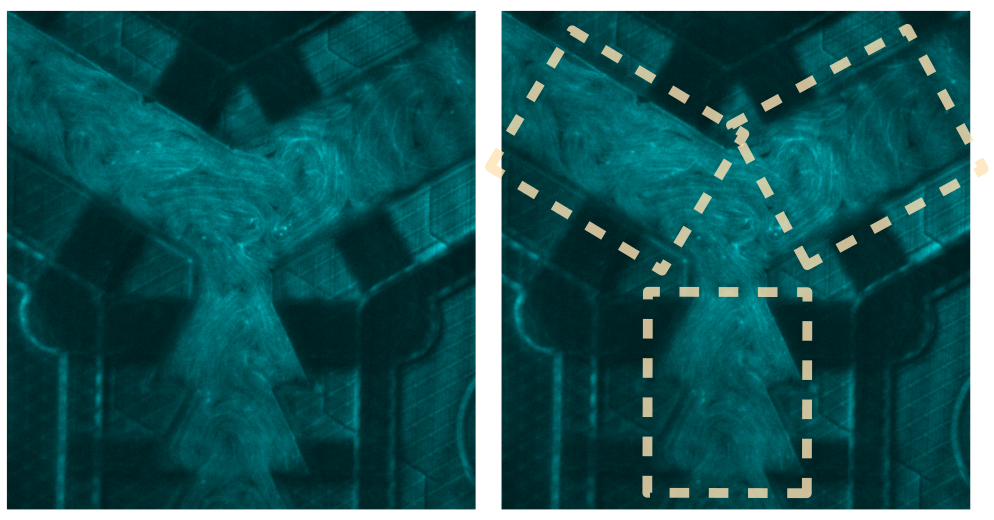

The above image (left) is an example microscopic view under a microscope. The bottom channel is modified with ratchet structures, and is therefore the inlet. The two branches on the top are the test channels. We want to measure the flow rate in the 3 channels separately. It's convenient to crop rectangular regions containing each branch, as shown in the right panel above. And then rotate the region to horizontal or vertical direction, so that the velocity along the channel direction is just the horizontal or vertical component of the measured velocity. 

In the following, let's write the code to crop the images. 

In [1]:
from skimage import io, draw
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myImageLib import readdata, bestcolor
import os
from pivLib import PIV, PIV_masked, read_piv, to_matrix, apply_mask
from IPython.display import clear_output
from corrLib import divide_windows, corrS

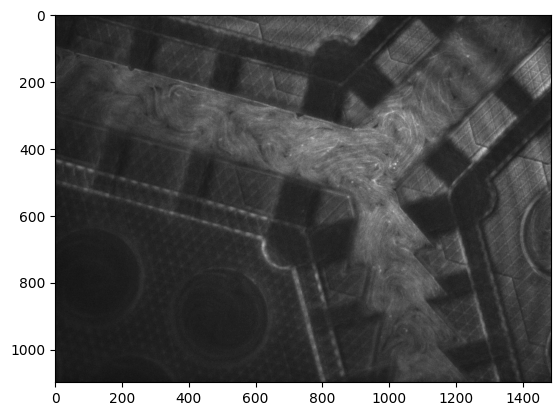

In [6]:
img = io.imread(r"test_files/crop-test.tif")
plt.imshow(img, cmap="gray")

The first step is to rotate the image, so that each channel have their +1 flow direction going up. This requires the knowledge of 3 rotation angle and 3 crop region coordinates after respective rotations. We start by mannually provide these numbers. <font color="red">Later on, we will develop more intelligent algorithm that crops the image more automatically.</font>

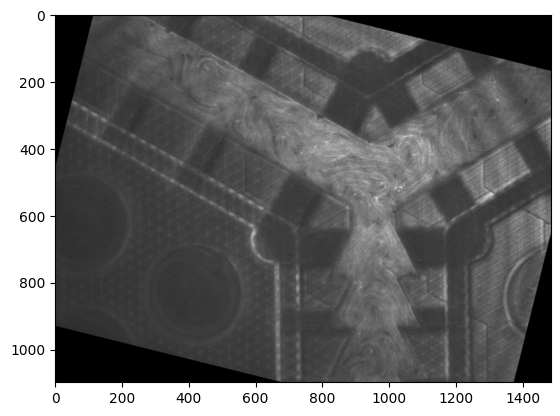

In [7]:
imgr = rotate(img, angle=-14)
plt.imshow(imgr, cmap="gray")

From ImageJ, we manually get 3 sets of (rotation angle, crop rectangle), saved in the "crop-data.csv" file as a table (picture below). Here, important information is the angle in odd lines and (BX, BY, Width, Height) in even lines. For example, to get the first crop of the inlet ratchet channel, we first rotate the raw image (angle[1]-90) degrees. Then, crop the resulting image using the rectangle cornered at (X, Y) with width and height (Width, Height) in the second line (2). 

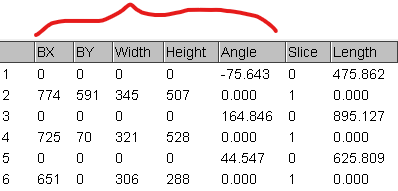

In [5]:
# load crop data from file
crop_data = pd.read_csv(r"test_files/crop-data.csv")
crop_data.head()

BX   BY  Width  Height    Angle  Slice   Length
0  1    0    0      0       0  104.357      0  475.862
1  2  774  591    345     507    0.000      1    0.000
2  3    0    0      0       0  164.846      0  895.127
3  4  725   70    321     528    0.000      1    0.000
4  5    0    0      0       0   44.547      0  625.809

In [6]:
# convert to angle, xy, wh
angle = 90 - crop_data.at[0, "Angle"]
x, y, w, h = crop_data.at[1, "BX"], crop_data.at[1, "BY"], crop_data.at[1, "Width"], crop_data.at[1, "Height"]

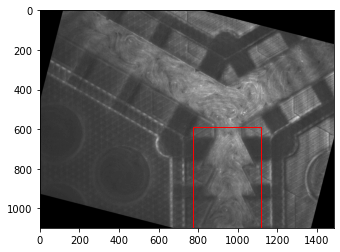

In [7]:
# show rotated image and crop region
imgr = rotate(img, angle=angle)
crop = imgr[y:y+h, x:x+w]
fig, ax = plt.subplots()
ax.imshow(imgr, cmap="gray")
rect = Rectangle((x, y), w, h, fill=False, ec="red")
ax.add_patch(rect)

Now, we write a function to preview all the crops. In this specific channel design, we will generate 3 crops from a single image. However, the function here should be compatible with arbitrary numbers of crops. 

In [8]:
def preview_crop(img, crop_data):
    """Preview the channel crops.
    Args:
    img -- raw image
    crop_data -- rotation angle and rectangle descriptor, generate manually from ImageJ
    """
    ncrops = len(crop_data) // 2
    img_in_row = 3
    nrows = ncrops // 3 + 1
    fig = plt.figure(figsize=(6, 2*nrows))
    
    for i in range(0, ncrops):
        angle = 90 - crop_data.at[2*i, "Angle"]
        x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
        imgr = rotate(img, angle=angle)
        crop = imgr[y:y+h, x:x+w]
        ax = fig.add_subplot(nrows, img_in_row, i+1)
        ax.imshow(crop, cmap="gray")

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


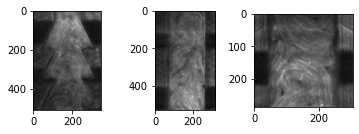

In [9]:
img = io.imread(r"test_files/crop-test.tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
preview_crop(img, crop_data)

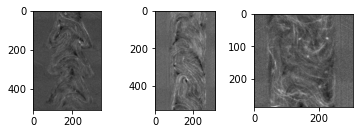

In [14]:
# preview real data
img = io.imread(r"E:/AN/10172022/05/remove-background/00000.tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
preview_crop(img, crop_data)

Next, we write a function to crop an image sequence, using the same crop-data.

In [11]:
def crop_sequence(sequence, crop_data, save_folder):
    """Crop an image sequence and save the resulting crops into respective folder.
    Crop folders will be named 0, 1, 2 ...
    Args:
    sequence -- return value of readdata
    crop_data -- manually generated ImageJ rotation and crop data
    save_folder -- master folder to save cropped images"""
    ncrops = len(crop_data) // 2
    crop_folder = {}
    for i in range(ncrops):
        crop_folder[i] = os.path.join(save_folder, "crop-{:d}".format(i))
        if os.path.exists(crop_folder[i]) == False:
            os.makedirs(crop_folder[i])
    for num, item in sequence.iterrows():
        img = io.imread(item.Dir)
        name = item.Name
        for i in range(0, ncrops):
            angle = 90 - crop_data.at[2*i, "Angle"]
            x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
            imgr = rotate(img, angle=angle)
            crop = imgr[y:y+h, x:x+w]
            io.imsave(os.path.join(crop_folder[i], "{}.tif".format(name)), crop, check_contrast=False)

In [12]:
seq = readdata("test_files", "tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
save_folder = r"test_files/cropped_images"
crop_sequence(seq, crop_data, save_folder)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
D:\miniconda\envs\py39\lib\site-packages\tifffile\tifffile.py:1570: UserWarning: TiffWriter: writing zero size array to nonconformant TIFF
  warnings.warn(


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:2595: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'cv::warpAffine'


### 1.1 Batch crop

In [67]:
# external disk test
folder = r"E:\AN\10172022"
for n in range(4, 19):
    seq = readdata(os.path.join(folder, "{:02d}".format(n), "remove-background"), "tif")
    crop_data = pd.read_csv(r"test_files/crop-data.csv")
    save_folder = os.path.join(folder, "channel_crops_rb", "{:02d}".format(n))
    if os.path.exists(save_folder) == False:
        crop_sequence(seq, crop_data, save_folder)

## 2 Flow rate analysis

### 2.1 PIV

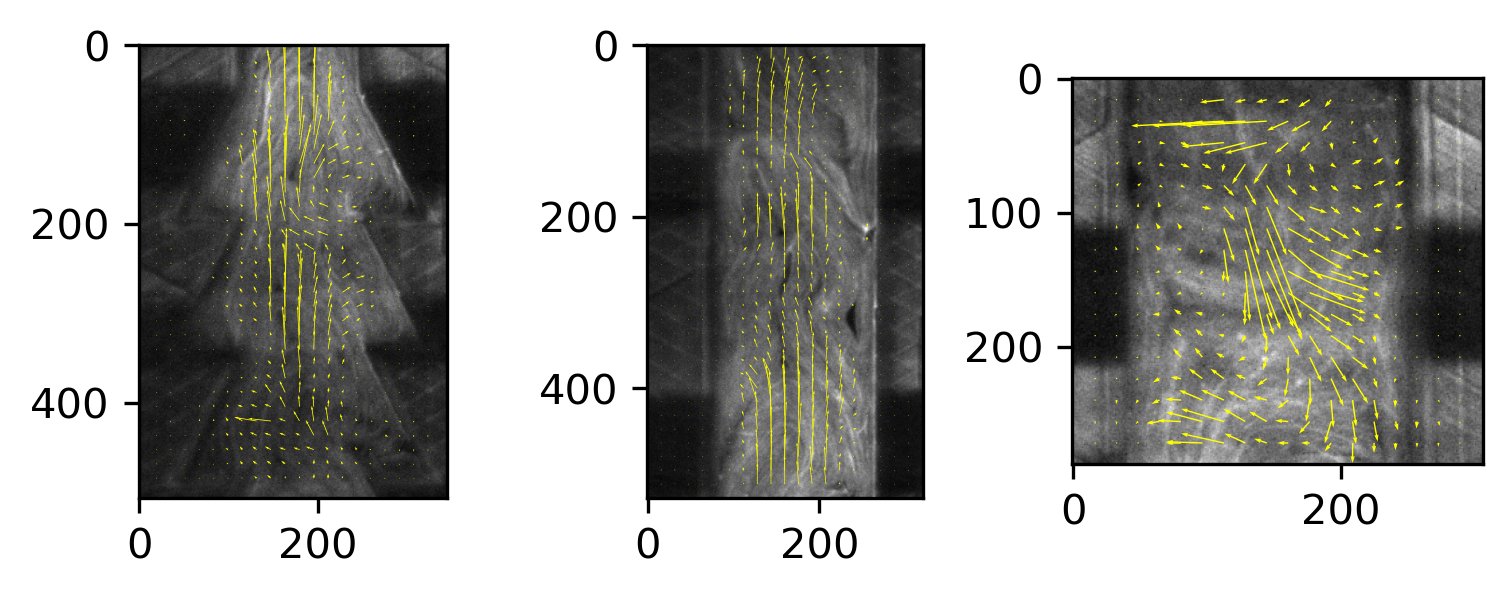

In [121]:
folder = r"E:\AN\10172022"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), dpi=300)
for i in range(3):
    I0 = io.imread(os.path.join(folder, "channel_crops_rb", "04", "crop-{:d}".format(i), "00000.tif"))
    I1 = io.imread(os.path.join(folder, "channel_crops_rb", "04", "crop-{:d}".format(i), "00001.tif"))
    x, y, u, v = PIV(I0, I1, 32, 16, 1)
    ax[i].imshow(I0, cmap="gray")
    ax[i].quiver(x, y, u, v, color="yellow")

### 2.2 Masked PIV

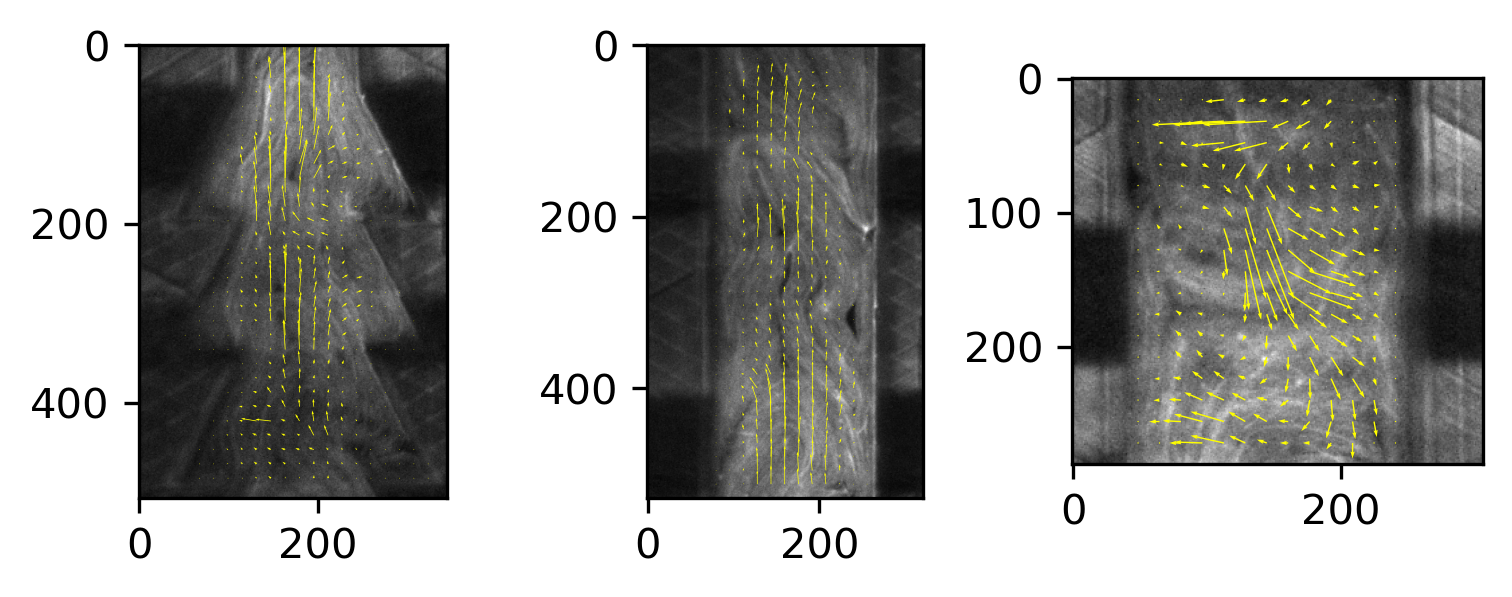

In [53]:
folder = r"E:\AN\10172022"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), dpi=300)
for i in range(3):
    I0 = io.imread(os.path.join(folder, "channel_crops", "04", "crop-{:d}".format(i), "00000.tif"))
    I1 = io.imread(os.path.join(folder, "channel_crops", "04", "crop-{:d}".format(i), "00001.tif"))
    mask = io.imread(os.path.join(folder, "channel_crops", "04", "masks", "crop-{:d}.tif".format(i)))
    x, y, u, v = PIV_masked(I0, I1, 32, 16, 1, mask)
    ax[i].imshow(I0, cmap="gray")
    ax[i].quiver(x, y, u, v, color="yellow")

#### 2.2.1 Batch PIV

In [59]:
sfL = ["crop-0", "crop-1", "crop-2"]
crop_folder = r"E:\AN\10172022\channel_crops_rb"
piv_folder = r"E:\AN\10172022\channel_piv_rb"
n = 4
winsize = 32
overlap = 16
dt = 1
for n in range(4, 5):
    for sf in sfL:
        img_folder = os.path.join(crop_folder, "{:02d}".format(n), sf)
        save_folder = os.path.join(piv_folder, "{:02d}".format(n), sf)
        if os.path.exists(save_folder) == False:
            os.makedirs(save_folder)
        l = readdata(img_folder, "tif")
        for i0, i1 in zip(l.index[::2], l.index[1::2]):
            I0 = io.imread(l.at[i0, "Dir"])
            I1 = io.imread(l.at[i1, "Dir"])
            x, y, u, v = PIV(I0, I1, winsize, overlap, dt)
            pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u.flatten(), "v": v.flatten()})
            pivData.to_csv(os.path.join(save_folder, "{0}-{1}.csv".format(l.at[i0, "Name"], l.at[i1, "Name"])), index=False)

#### 2.2.2 Check PIV results

In [5]:
n = 4
limg = readdata(os.path.join(crop_folder, "{:02d}".format(n), "crop-0"), "tif")
lpiv = readdata(os.path.join(piv_folder, "{:02d}".format(n), "crop-0"), "csv")
for i in range(len(lpiv)):
    img = io.imread(limg.at[i*2, "Dir"])
    x, y, u, v = read_piv(lpiv.at[i, "Dir"])
    plt.imshow(img, cmap="gray")
    plt.quiver(x, y, u, v, color="yellow")
    plt.pause(0.1)
    clear_output(wait=True)

C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\matplotlib\quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

#### 2.2.3 Normal PIV on background-removed images

In [37]:
img_folder = r"E:\AN\10122022\00\remove-background"
save_folder = r"E:\AN\10122022\PIV\00"
winsize = 32
overlap = 16
dt = 1

if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
l = readdata(img_folder, "tif")
for i0, i1 in zip(l.index[::2], l.index[1::2]):
    I0 = io.imread(l.at[i0, "Dir"])
    I1 = io.imread(l.at[i1, "Dir"])
    x, y, u, v = PIV(I0, I1, winsize, overlap, dt)
    pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u.flatten(), "v": v.flatten()})
    pivData.to_csv(os.path.join(save_folder, "{0}-{1}.csv".format(l.at[i0, "Name"], l.at[i1, "Name"])), index=False)

#### 2.2.4 Apply mask

In [70]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(5, 6):
    for sf in sfL:
        mask_raw = io.imread(os.path.join(mask_folder, "{}.tif".format(sf)))
        X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
        mask_bool = mask >= mask.max()
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        for num, i in l.iterrows():
            x, y, u, v = read_piv(i.Dir)
            u[~mask_bool] = np.nan
            v[~mask_bool] = np.nan
            pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u.flatten(), "v": v.flatten()})
            pivData.to_csv(i.Dir, index=False)

### 2.3 Velocity field to flow rate

We assume the active nematics system is imcompressible and use volumetric flow rate $Q$ as the flow rate that should be conserved at each point in the channel. 

In each of the cropped channel region, we know from the videos that the primary flow direction is along the channel directions, either being positive or negative. Therefore, we only extract flow in these directions, i.e. the $y$-axis in the cropped images. To get $Q_y$, we integrate velocity $v_y$ along $x$ at an arbitrary $y$ position:
$$
Q_y = \int_{x_1}^{x_2} v_y(x, y)dx
$$
To minimize the noise from the arbitrary choice of $y$ position, we can take an average of $Q_y$ over $y$:
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} Q_y dy = \frac{1}{L}\int_0^{L} \int_{x_1}^{x_2} v_y(x, y)dx dy
$$
For a rectangular channel, $x_1$ and $x_2$ are constant for all $y$, so the mean flow rate can be simplified to 
$$
\left< Q_y \right> = W \left< v_y \right>_{x, y}
$$
For ratchet channels (or other non-rectangular channels), where channel width $W$ is not a constant along $y$, we need to compute
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} W(y) \left<v_y\right>_x dy
$$

In [71]:
def compute_flowrate(v, winsize):
    """Compute flow rate in channels based on masked PIV data.
    Args:
    v -- masked PIV velocity in channel direction. (px/s) ([x, y(, t)] array)
    winsize -- PIV window size in pixel. (px) 
    Returns:
    Q -- flow rate (px^2/s)
    IMPORTANT:
    Overlap is always half of winsize."""
    mask = ~np.isnan(v)
    W = np.count_nonzero(mask, axis=1) # channel width (number of windows)
    w = W * winsize / 2 # channel width (px)
    v_meanx = np.nanmean(v, axis=1)
    Q = np.nanmean(w * v_meanx, axis=0)
    return Q

In [72]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
if os.path.exists(flowrate_folder) == False:
    os.makedirs(flowrate_folder)
n = 4
winsize = 32
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(4, 19):
    df = pd.DataFrame()
    for sf in sfL:
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        tmp = []
        for num, i in l.iterrows():
            x, y, u, v = read_piv(i.Dir)
            tmp.append(v)
        vstack = np.stack(tmp, axis=2)
        Q = compute_flowrate(vstack, winsize)
        df[sf] = Q
    # set time column
    df["t"] = df.index * 2 # 1 fps, PIV 2 frame
    df.to_csv(os.path.join(flowrate_folder, "{:02}.csv".format(n)), index=False)

C:\Users\liuzy\AppData\Local\Temp\ipykernel_19564\396871552.py:13: RuntimeWarning: Mean of empty slice
  v_meanx = np.nanmean(v, axis=1)


### 2.4 Plot flow rate time series

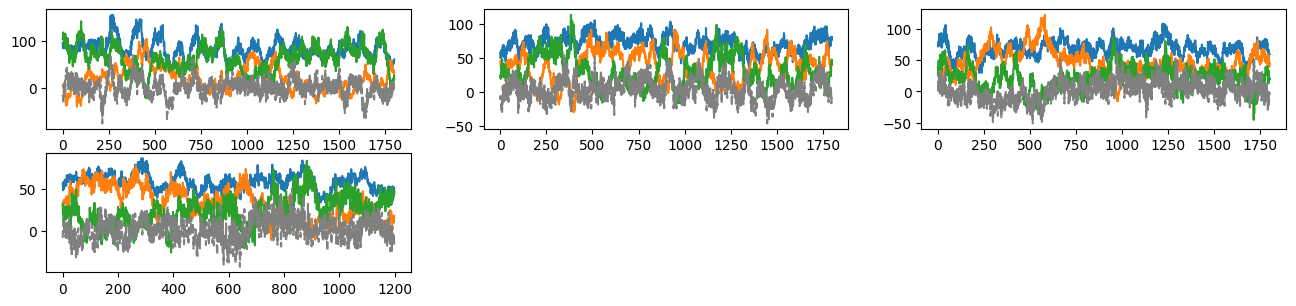

In [256]:
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
n = 13
fig = plt.figure(figsize=(16, 9), dpi=100)
for num, n in enumerate(range(1,5)):
    data = pd.read_csv(os.path.join(flowrate_folder, "{:02d}.csv".format(n)))
    ax = fig.add_subplot(5, 3, num+1)
    ax.plot(data.t, data["crop-0_rb"], label="$A$")
    ax.plot(data.t, data["crop-1_rb"], label="$B$")
    ax.plot(data.t, data["crop-2_rb"], label="$C$")
    # ax.set_xlabel("$t$ (s)")
    # ax.set_ylabel("flow rate (px$^2$/s)")
    ax.plot(data.t, data["crop-0_rb"] - data["crop-1_rb"] - data["crop-2_rb"], color="gray", ls="--", label="$A-B-C$")
    
    # ax.legend(frameon=False)

### 2.5 Normalize flow rate

In [74]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
flow_data = pd.read_csv(os.path.join(flowrate_folder_rb, "14.csv"))
flow_data.head()

crop-0      crop-1      crop-2  t
0  370.817845  653.337855 -195.456327  0
1  343.999827  667.574907 -180.495546  2
2  317.374682  703.399163 -154.375359  4
3  270.075610  586.576472 -241.117395  6
4  291.124701  621.510550 -235.715612  8

In [75]:
norm = flow_data["crop-0"].mean()
norm_flow_data = flow_data.copy()
mean0 = norm_flow_data["crop-0"].mean()
norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0

Text(0, 0.5, 'flow rate (px$^2$/s)')

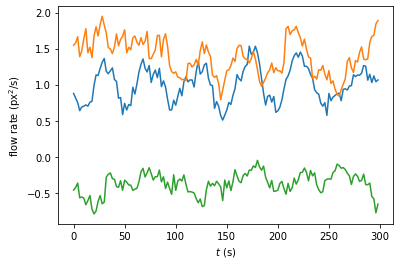

In [78]:
fig, ax = plt.subplots()
ax.plot(norm_flow_data.t, norm_flow_data["crop-0"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-1"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-2"])
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")

## 3 Test preprocess - subtract background (in particular the dark concentric rings)

We notice that the images from the Gulliver confocal always have outstanding concentric dark rings, likely caused by the confocal spin unit (CSU). In the previous sections, we have analyzed the images without correcting these rings. Here, we compare the results from with/without correction, to see if a correction is necessary. If necessary, we will implement a python version of batch background subtration. 

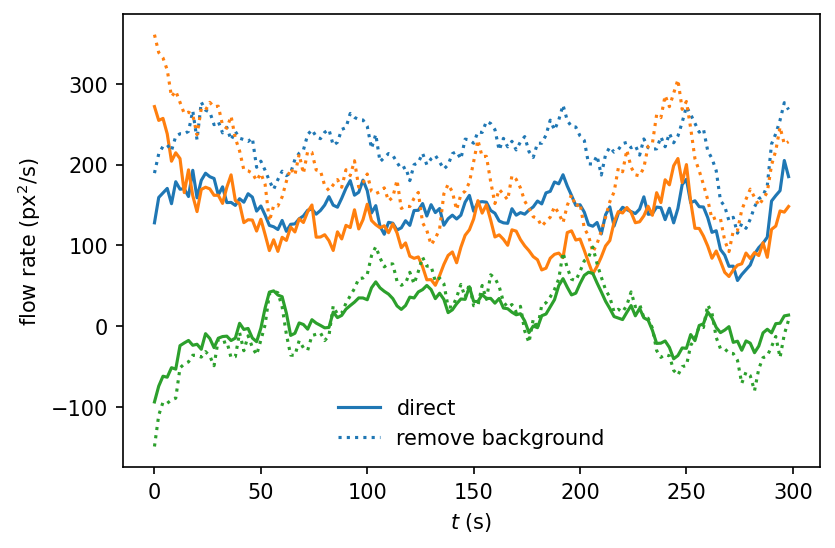

In [30]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate"
flowrate_folder_rb = r"E:\AN\10172022\channel_flowrate_rb"
n = 5
# fig = plt.figure(figsize=(16, 9), dpi=100)
fig, ax = plt.subplots(dpi=150)
data = pd.read_csv(os.path.join(flowrate_folder, "{:02d}.csv".format(n)))
data_rb = pd.read_csv(os.path.join(flowrate_folder_rb, "{:02d}.csv".format(n)))
# ax = fig.add_subplot(5, 3, num+1)
ax.plot(data.t, data["crop-0"], label="direct", color=bestcolor(0))
ax.plot(data.t, data["crop-1"], color=bestcolor(1))
ax.plot(data.t, data["crop-2"], color=bestcolor(2))
ax.plot(data.t, data_rb["crop-0"], label="remove background", color=bestcolor(0), ls=":")
ax.plot(data.t, data_rb["crop-1"], color=bestcolor(1), ls=":")
ax.plot(data.t, data_rb["crop-2"], color=bestcolor(2), ls=":")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")
# ax.plot(data.t, data["crop-0"] - data["crop-1"] - data["crop-2"], color="gray", ls="--", label="$A-B-C$")

ax.legend(frameon=False)

The above comparison suggests that there is noticealbe difference between PIV on images with/without background subtraction. On images where background is subtracted, the measured velocity is generally larger than original images. This is expected because the dark rings in the images are stationary patterns, which make the detected motion slower. In the future, all the PIV should be done on images where background is subtracted. Here, we implement a code to batch process raw images. 

### 3.1 Implement background subtraction

- Median z-projection
- divide raw images by the projection

In [32]:
raw_folder = r"E:\AN\10122022\00\raw"
rb_folder = r"E:\AN\10122022\00\remove-background"
if os.path.exists(rb_folder) == False:
    os.makedirs(rb_folder)
l = readdata(raw_folder, "tif")
imgs = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    imgs.append(img)
stack = np.stack(imgs, axis=0) # TXY image stack

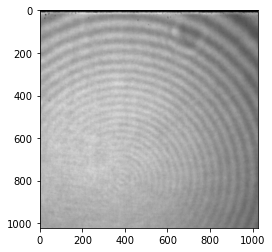

In [33]:
# median projection
med = np.median(stack, axis=0)
plt.imshow(med, cmap="gray")

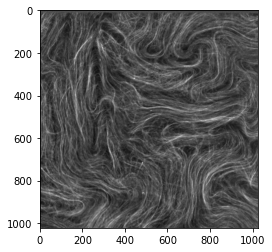

In [34]:
img = stack[0]
plt.imshow(img/med, cmap="gray")

In [52]:
subtract_stack = np.divide(stack, med)
img = subtract_stack[0]
plt.imshow(img, cmap="gray")

MemoryError: Unable to allocate 43.7 GiB for an array with shape (3601, 1098, 1484) and data type float64

Unable to do `np.divide` in the current configuration, because memory is not enough. 

In [35]:
imgr0 = stack[0] / med
low, high = imgr0.min(), imgr0.max()
for num, img in enumerate(stack):
    imgr = img / med
    img8 = ((imgr - low) / (high - low) * 255).astype(np.uint8)
    io.imsave(os.path.join(rb_folder, "{:05d}.tif".format(num)), img8)

**Batch remove background**

In [66]:
folder = r"E:\AN\10172022"
n = 4
for n in range(5, 19):
    raw_folder = r"E:\AN\10172022\{:02d}\raw".format(n)
    rb_folder = r"E:\AN\10172022\{:02d}\remove-background".format(n)
    if os.path.exists(rb_folder) == False:
        os.makedirs(rb_folder)
    else:
        continue
    l = readdata(raw_folder, "tif")
    imgs = []
    for num, i in l.iterrows():
        img = io.imread(i.Dir)
        imgs.append(img)
    stack = np.stack(imgs, axis=0) # TXY image stack

    med = np.median(stack, axis=0)

    imgr0 = stack[0] / med
    low, high = imgr0.min(), imgr0.max()
    for num, img in enumerate(stack):
        imgr = img / med
        img8 = ((imgr - low) / (high - low) * 255).astype(np.uint8)
        io.imsave(os.path.join(rb_folder, "{:05d}.tif".format(num)), img8)

## 4 Flow configuration probability

We plot the probability of flow configuration on a $\phi_B$-$\phi_C$ axis.

In [217]:
flowrate_folder = r"C:\Users\liuzy\Documents\10172022\04"
flow_data = pd.read_csv(os.path.join(flowrate_folder, "flowrate.csv"))
flow_data.head()

crop-0      crop-1      crop-2  t
0  379.661608  411.381052  -94.305390  0
1  247.928972  341.664000  -95.563626  1
2  206.866166  420.423743 -184.947396  2
3  205.057971  431.254114 -183.407506  3
4  224.290620  411.595539 -176.983738  4

### 4.1 Normalize the flow rate data

In [218]:
norm = flow_data["crop-0"].mean()
norm_flow_data = flow_data.copy()
mean0 = norm_flow_data["crop-0"].mean()
norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0

Text(0, 0.5, 'flow rate (px$^2$/s)')

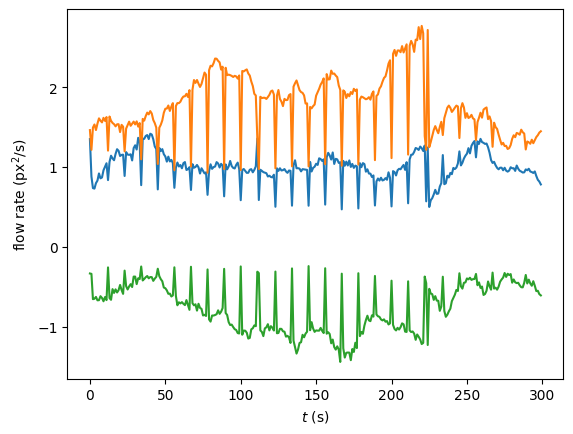

In [219]:
fig, ax = plt.subplots()
ax.plot(norm_flow_data.t, norm_flow_data["crop-0"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-1"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-2"])
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")

### 4.2 Histogram of normalized flow rate

In [215]:
H, xedges, yedges = np.histogram2d(norm_flow_data["crop-1"], norm_flow_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])

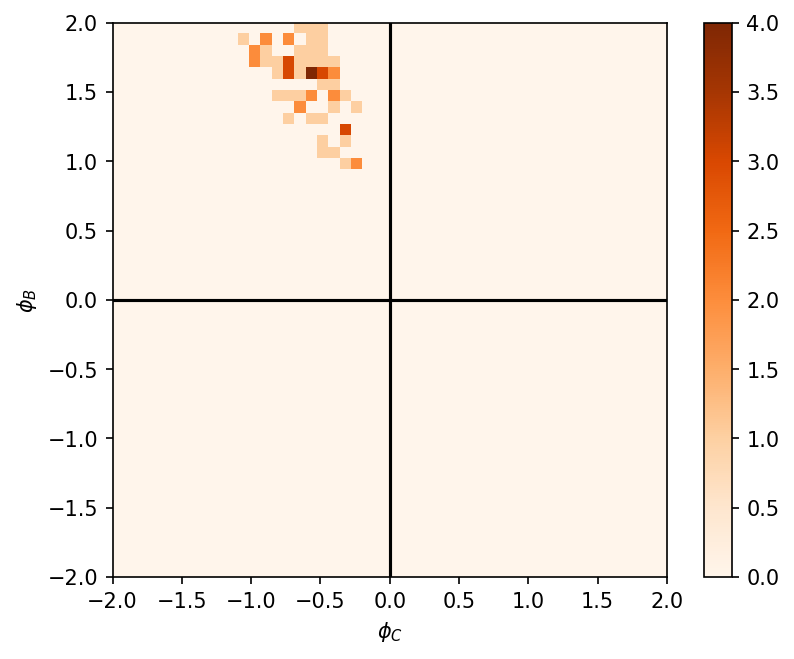

In [216]:
plt.figure(dpi=150)
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black")
plt.plot([0, 0], [-2, 2], color="black")
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")
plt.colorbar()

Text(0, 0.5, '$\\phi_B$')

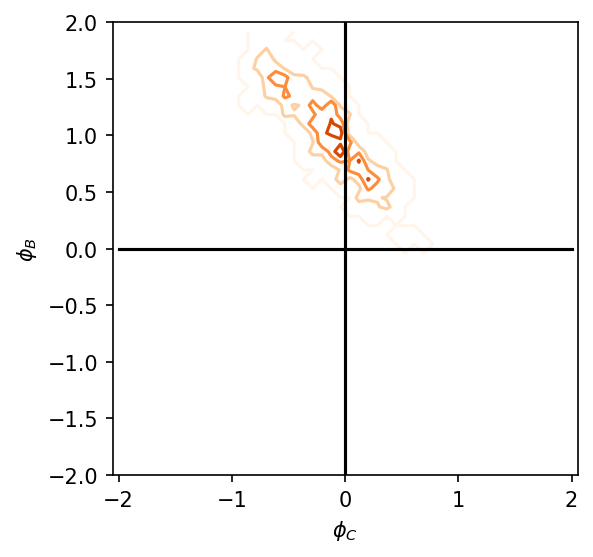

In [155]:
# Contour plot
plt.figure(figsize=(4, 4), dpi=150)
levels = np.linspace(np.min(H), np.max(H), 5)

plt.axis("equal")
plt.contour(xedges[:-1], yedges[:-1], H, levels=levels, cmap="Oranges")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black")
plt.plot([0, 0], [-2, 2], color="black")
# plt.colorbar()
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")

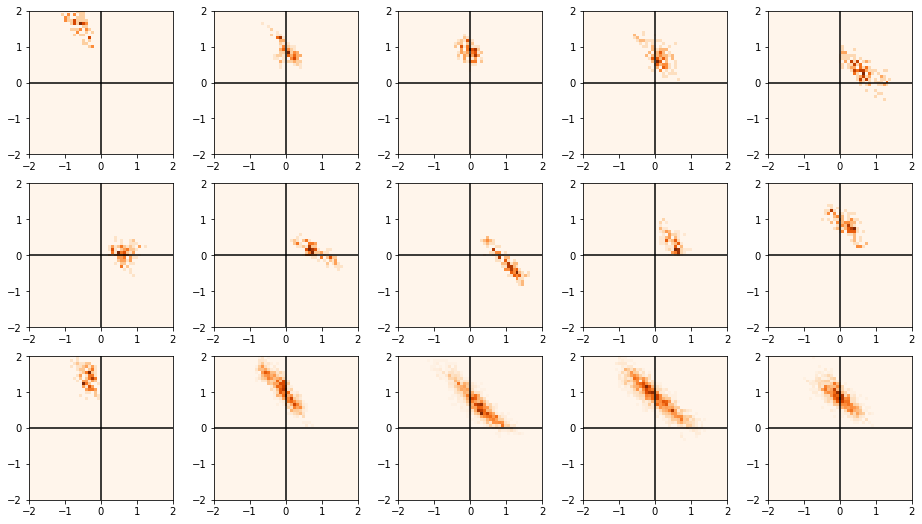

In [160]:
fig = plt.figure(figsize=(16, 9))
num = 1
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"

for n in range(4, 19):
    ax = fig.add_subplot(3, 5, num)
    flow_data = pd.read_csv(os.path.join(flowrate_folder_rb, "{:02d}.csv".format(n)))
    norm = flow_data["crop-0"].mean()
    norm_flow_data = flow_data.copy()
    mean0 = norm_flow_data["crop-0"].mean()
    norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0
    H, xedges, yedges = np.histogram2d(norm_flow_data["crop-1"], norm_flow_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black")
    ax.plot([0, 0], [-2, 2], color="black")
    num += 1

In [14]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
l = readdata(flowrate_folder, "csv")
flow_list = []
for num, i in l.iterrows():
    flow_data = pd.read_csv(i.Dir)
    flow_list.append(flow_data)
data = pd.concat(flow_list)

In [18]:
data

crop-0      crop-1      crop-2     t
0     284.903891  340.803741  -68.501938     0
1     232.526922  344.393668  -87.746131     2
2     230.371388  340.838579  -84.528879     4
3     213.858281  313.205306  -64.247718     6
4     214.690617  283.612907  -81.880799     8
...          ...         ...         ...   ...
1095  626.656957  524.968666  -64.303204  2190
1096  632.669688  364.434556  -31.345588  2192
1097  596.160480  437.964529   52.103395  2194
1098  495.850733  497.187587  121.681686  2196
1099  641.734328  426.872548   64.186242  2198

[7381 rows x 4 columns]

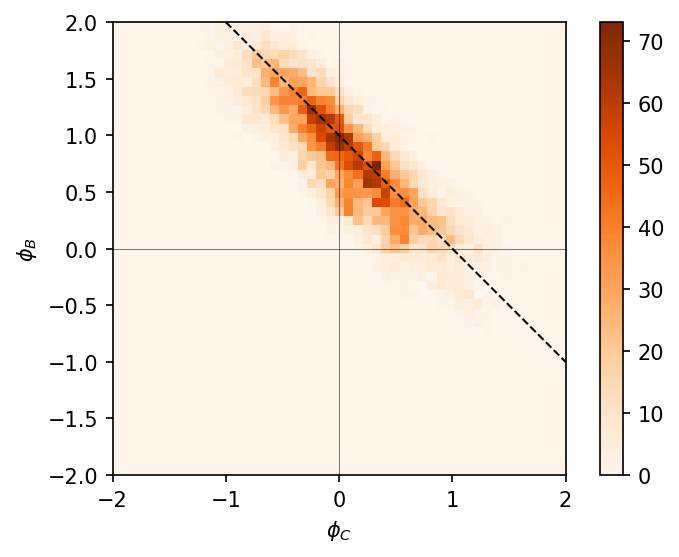

In [17]:
norm_data = data.copy()
norm_data[["crop-0", "crop-1", "crop-2"]] /= norm_data["crop-0"].mean()
H, xedges, yedges = np.histogram2d(norm_data["crop-1"], norm_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
plt.figure(dpi=150)
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
plt.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
plt.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")
plt.colorbar()

### 4.3 Histogram along the "mass conservation" line (black dashed line)

In [22]:
line_pixels = H[draw.line(48, 12, 12, 48)]

Text(0, 0.5, 'histogram')

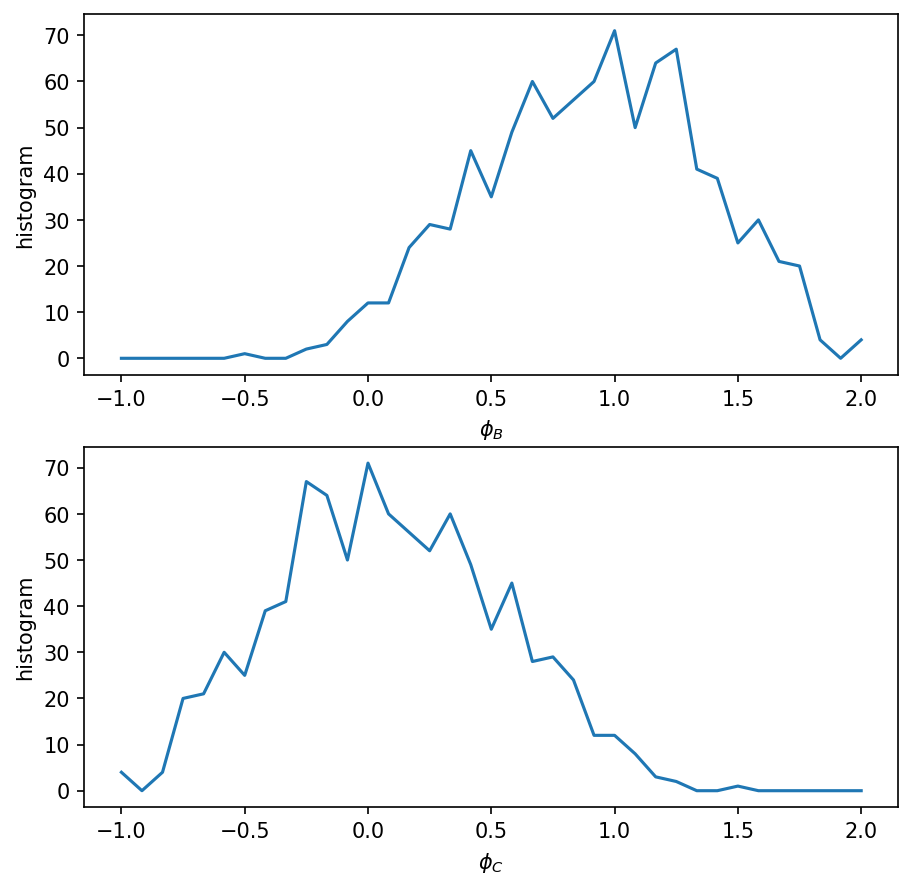

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), dpi=150)
ax[0].plot(np.linspace(2, -1, len(line_pixels)), line_pixels)
ax[0].set_xlabel("$\phi_B$")
ax[0].set_ylabel("histogram")
ax[1].plot(np.linspace(-1, 2, len(line_pixels)), line_pixels)
ax[1].set_xlabel("$\phi_C$")
ax[1].set_ylabel("histogram")

### 4.4 Data visualization by date

#### 4.4.1 10312022 Data

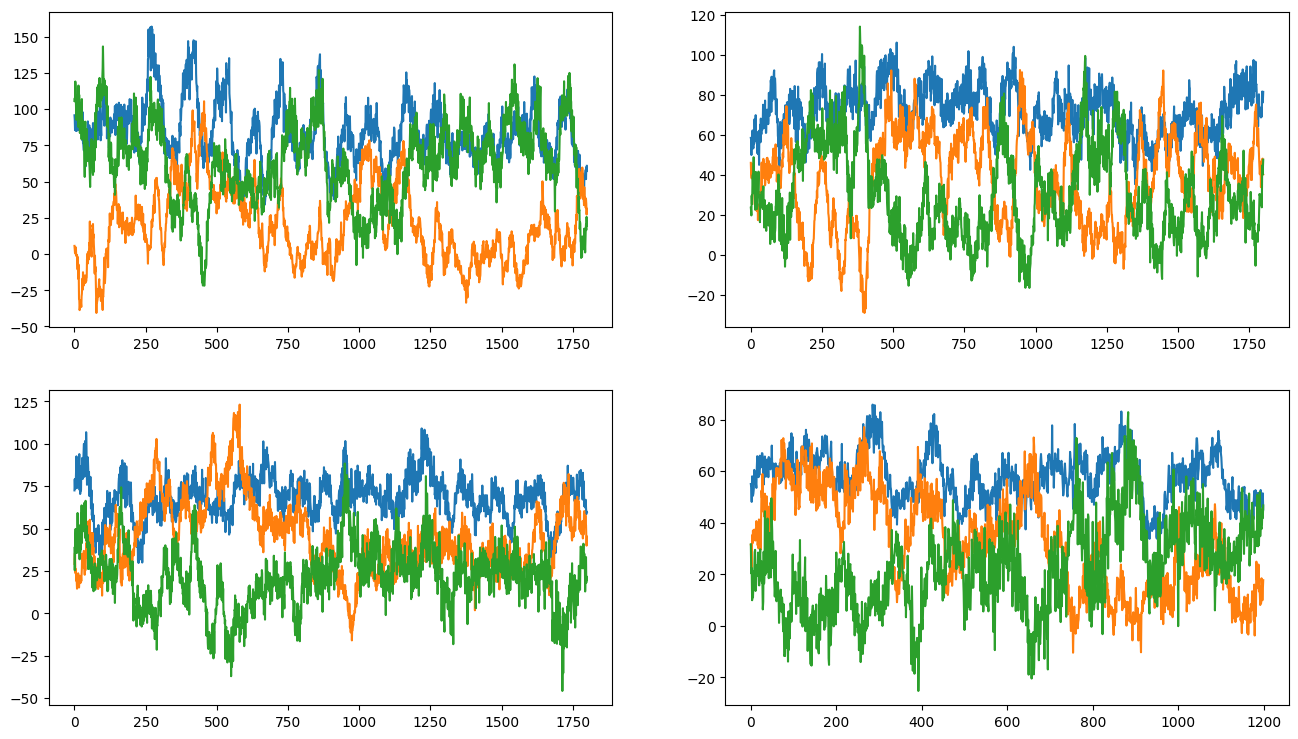

In [257]:
# flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    ax.plot(fr["t"], fr["crop-0_rb"])
    ax.plot(fr["t"], fr["crop-1_rb"])
    ax.plot(fr["t"], fr["crop-2_rb"])

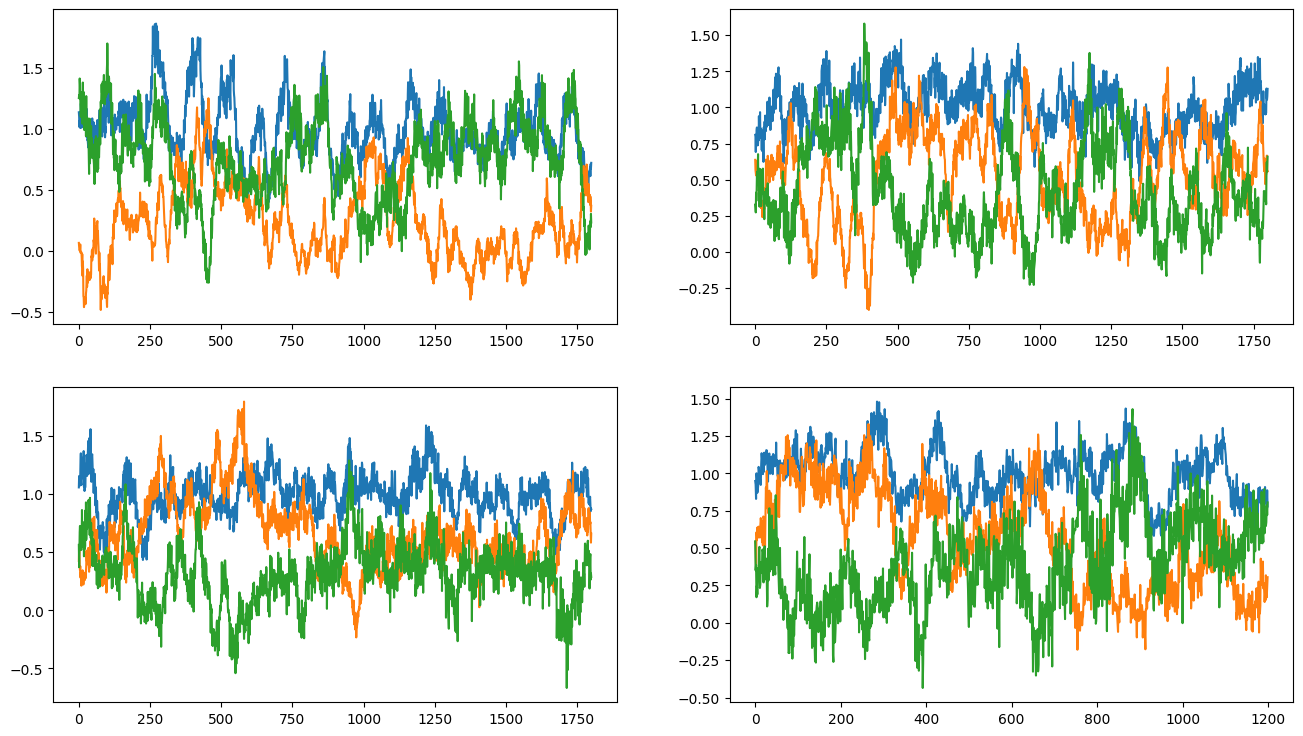

In [259]:
# normalized flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm = fr["crop-0_rb"].mean()
    ax.plot(fr["t"], fr["crop-0_rb"]/norm)
    ax.plot(fr["t"], fr["crop-1_rb"]/norm)
    ax.plot(fr["t"], fr["crop-2_rb"]/norm)

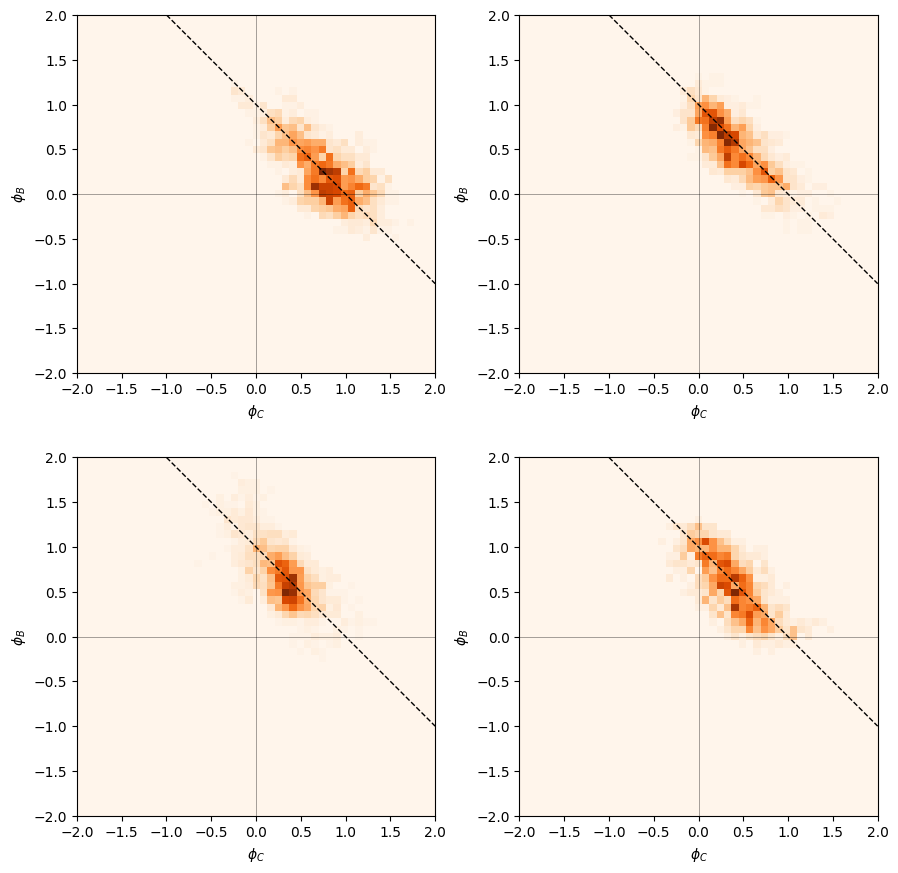

In [265]:
# Histogram of normalized flow rate (each)
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm_data["crop-0_rb"].mean()
    H, xedges, yedges = np.histogram2d(norm_data["crop-1_rb"], norm_data["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
    ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
    ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
    ax.set_xlabel("$\phi_C$")
    ax.set_ylabel("$\phi_B$")
plt.tight_layout()

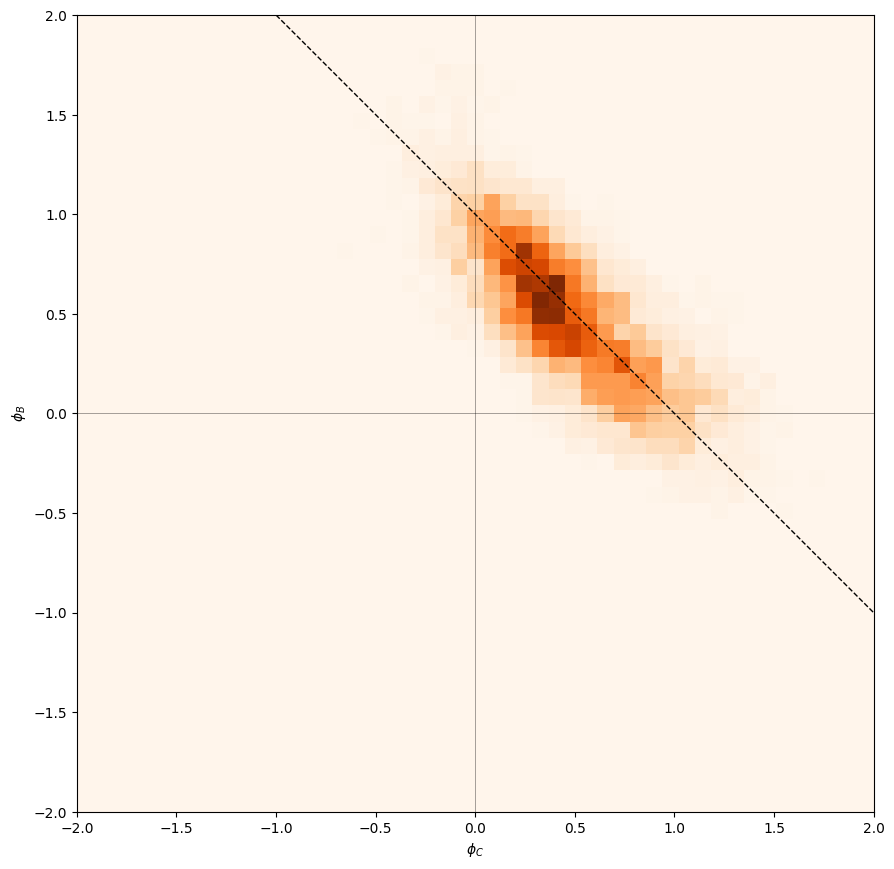

In [266]:
# Combine the histogram
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
data = []
for num, i in l.iterrows():    
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm_data["crop-0_rb"].mean()
    data.append(norm_data)
combine = pd.concat(data, axis=0)
H, xedges, yedges = np.histogram2d(combine["crop-1_rb"], combine["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(H, interpolation='nearest', origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
ax.set_xlabel("$\phi_C$")
ax.set_ylabel("$\phi_B$")
plt.tight_layout()

#### 4.4.2 11042022 Data

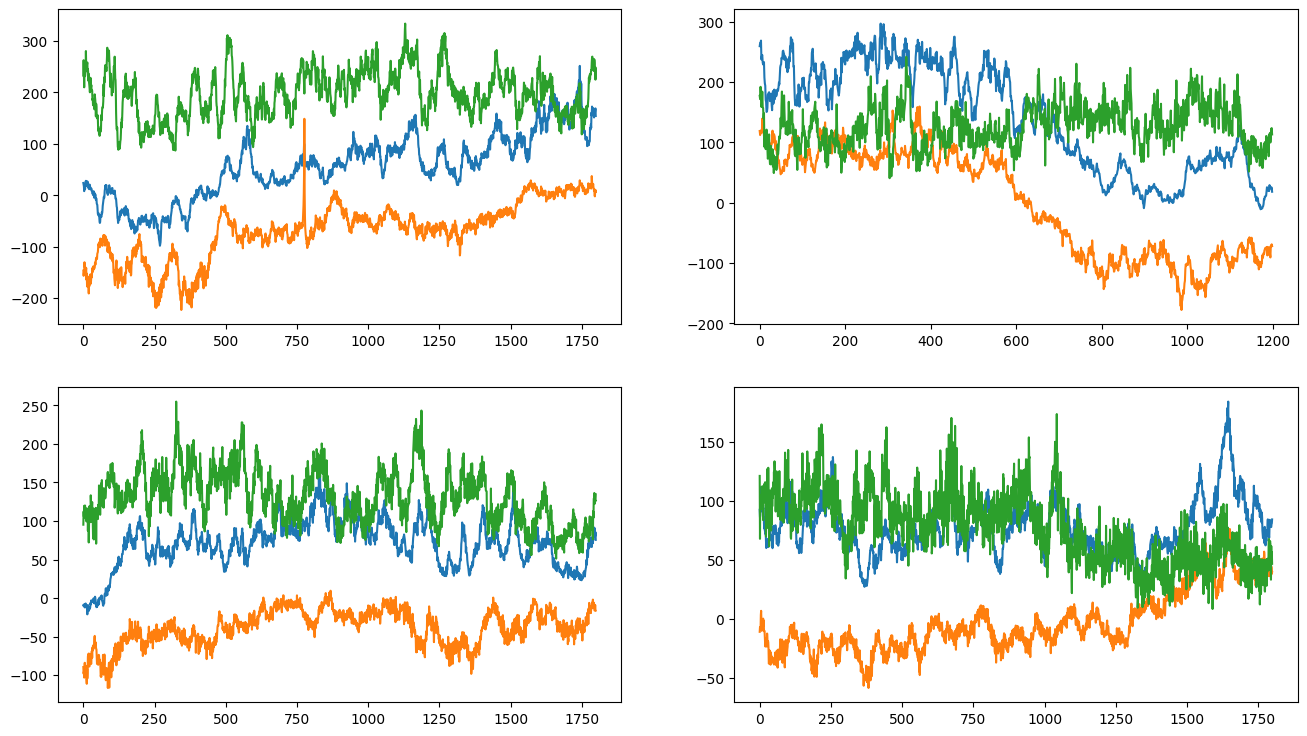

In [273]:
# flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    ax.plot(fr["t"], fr["crop-0_rb"])
    ax.plot(fr["t"], fr["crop-1_rb"])
    ax.plot(fr["t"], fr["crop-2_rb"])

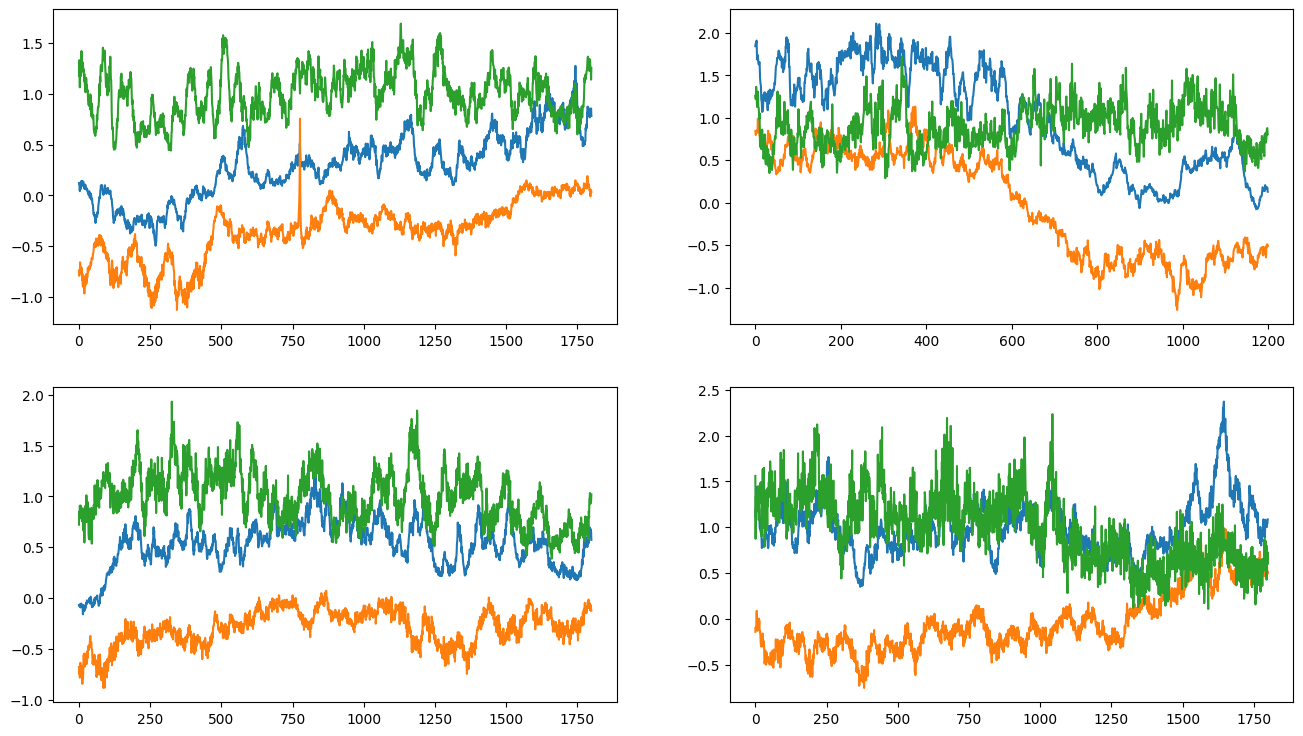

In [280]:
# normalized flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    ax.plot(fr["t"], fr["crop-0_rb"]/norm)
    ax.plot(fr["t"], fr["crop-1_rb"]/norm)
    ax.plot(fr["t"], fr["crop-2_rb"]/norm)

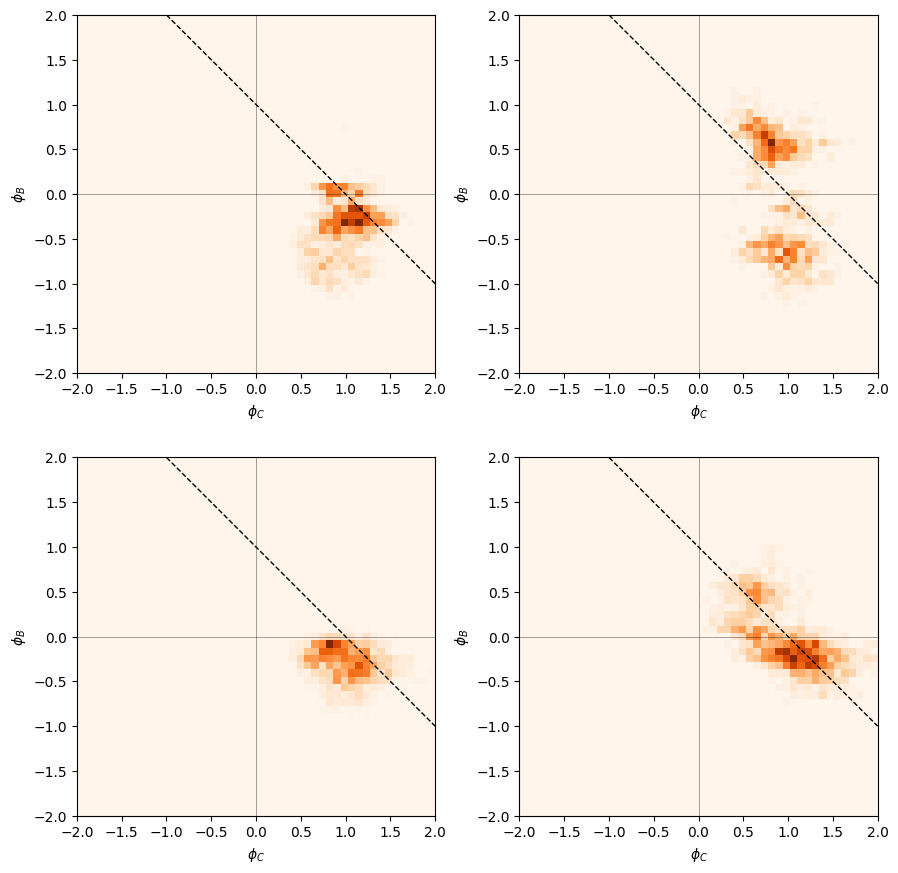

In [281]:
# Histogram of normalized flow rate (each)
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    H, xedges, yedges = np.histogram2d(norm_data["crop-1_rb"], norm_data["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
    ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
    ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
    ax.set_xlabel("$\phi_C$")
    ax.set_ylabel("$\phi_B$")
plt.tight_layout()

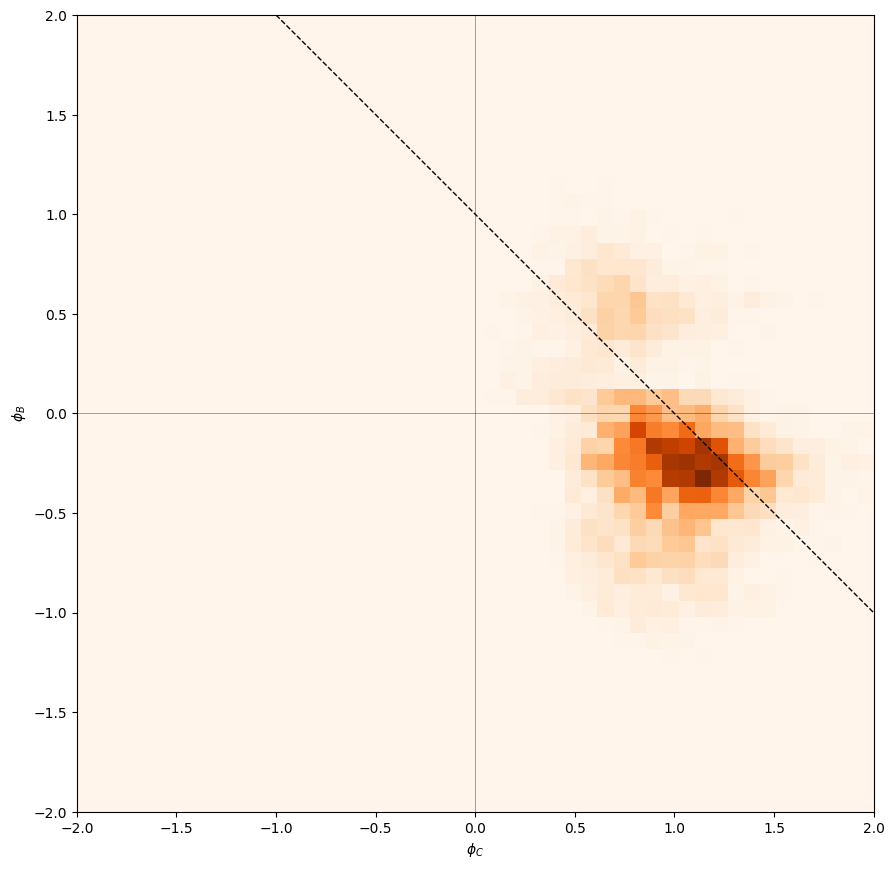

In [282]:
# Combine the histogram
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
data = []
for num, i in l.iterrows():    
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    data.append(norm_data)
combine = pd.concat(data, axis=0)
H, xedges, yedges = np.histogram2d(combine["crop-1_rb"], combine["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(H, interpolation='nearest', origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
ax.set_xlabel("$\phi_C$")
ax.set_ylabel("$\phi_B$")
plt.tight_layout()

#### 4.4.3 11072022 Data

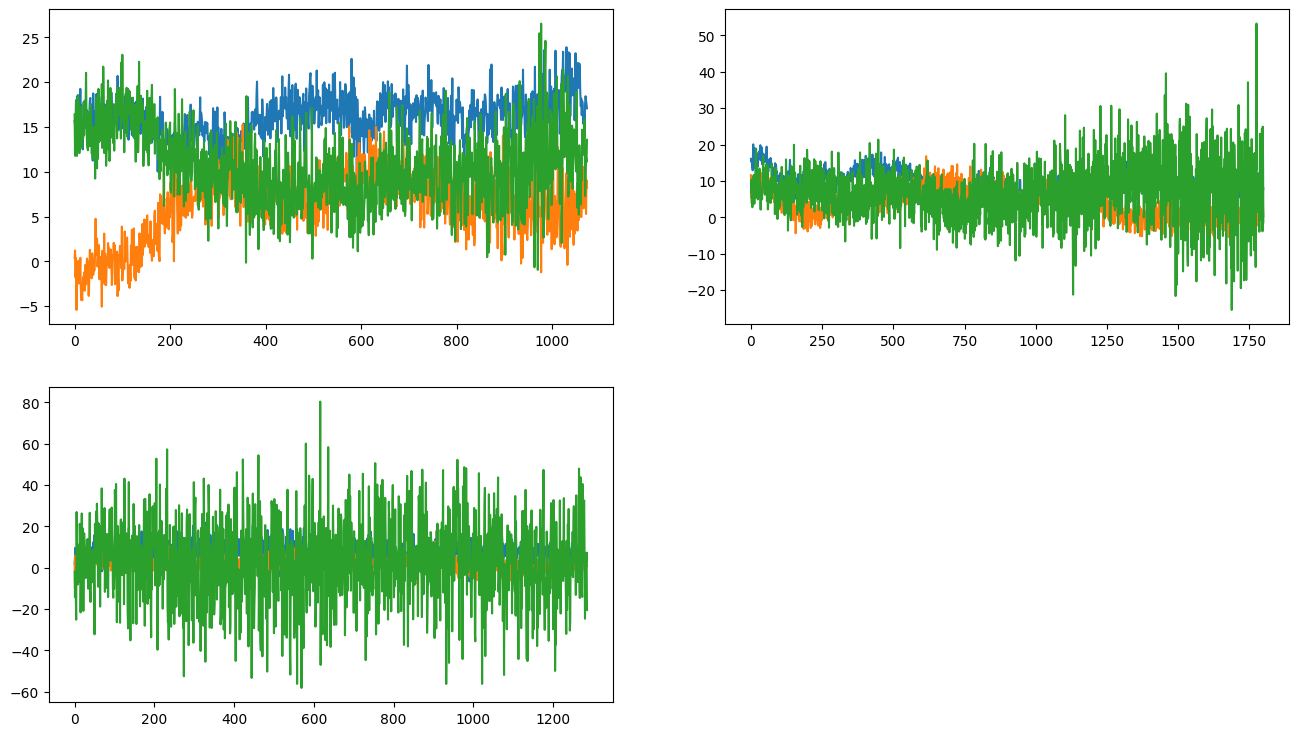

In [283]:
# flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    ax.plot(fr["t"], fr["crop-0_rb"])
    ax.plot(fr["t"], fr["crop-1_rb"])
    ax.plot(fr["t"], fr["crop-2_rb"])

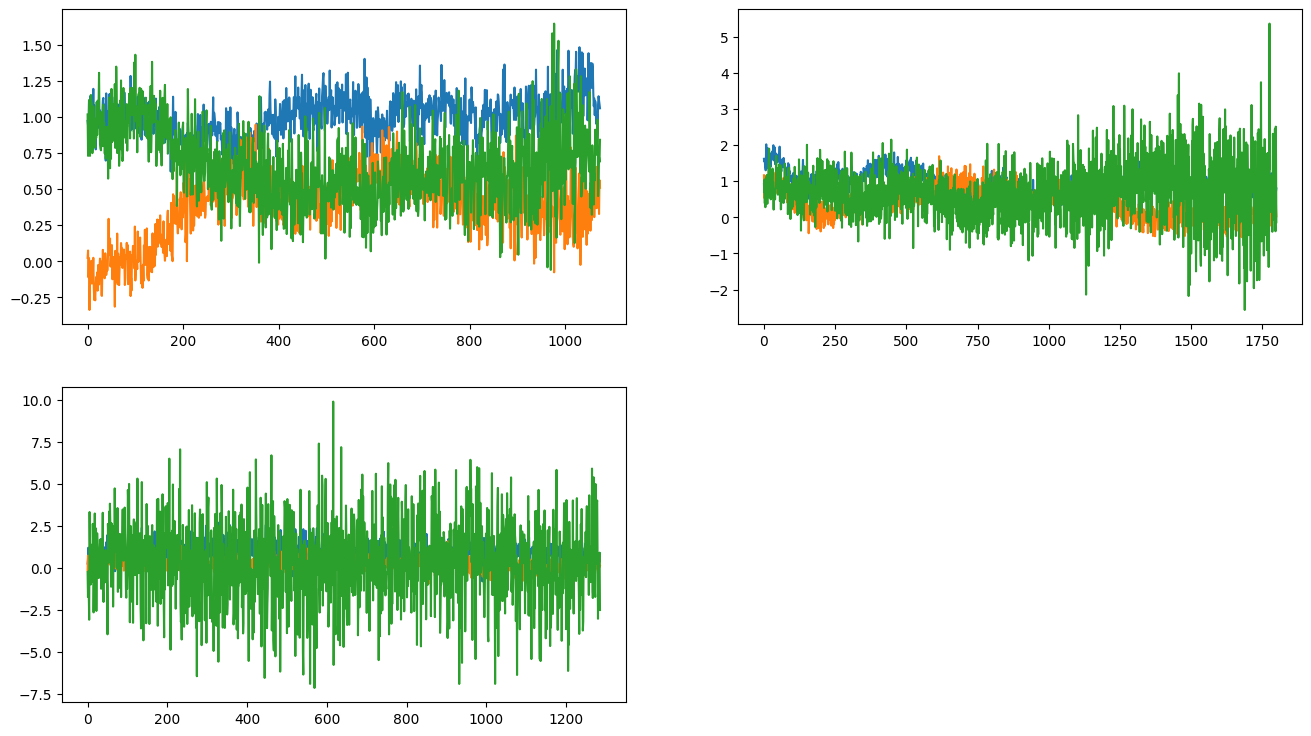

In [284]:
# normalized flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    ax.plot(fr["t"], fr["crop-0_rb"]/norm)
    ax.plot(fr["t"], fr["crop-1_rb"]/norm)
    ax.plot(fr["t"], fr["crop-2_rb"]/norm)

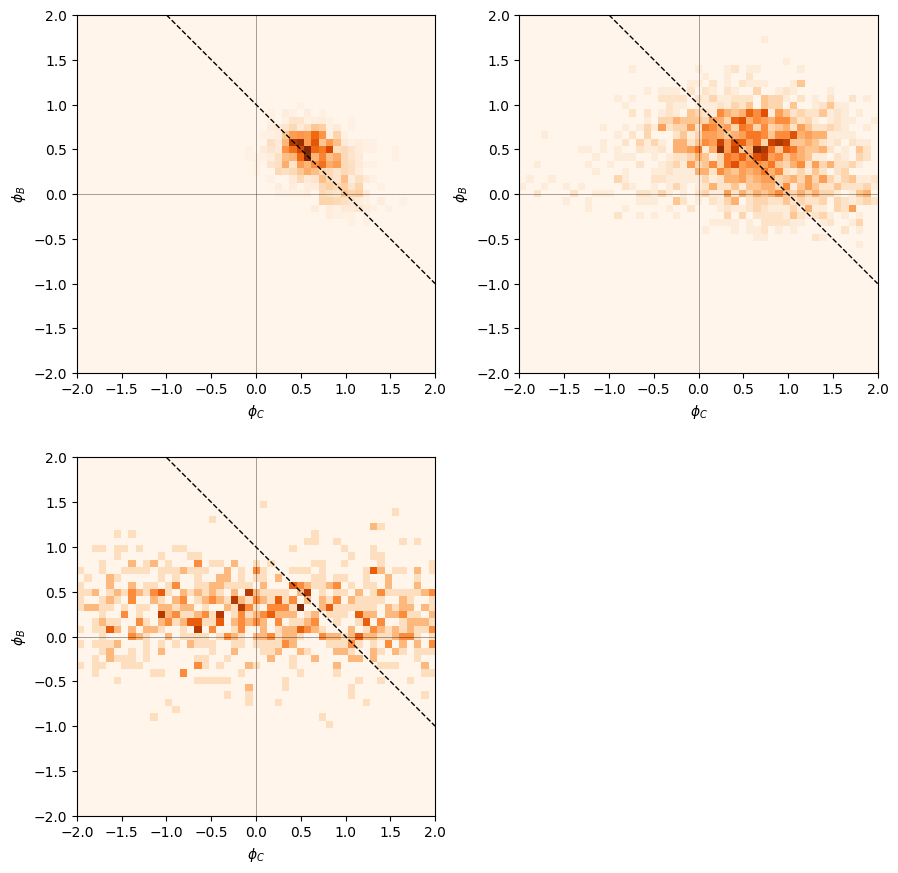

In [286]:
# Histogram of normalized flow rate (each)
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    H, xedges, yedges = np.histogram2d(norm_data["crop-1_rb"], norm_data["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
    ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
    ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
    ax.set_xlabel("$\phi_C$")
    ax.set_ylabel("$\phi_B$")
plt.tight_layout()

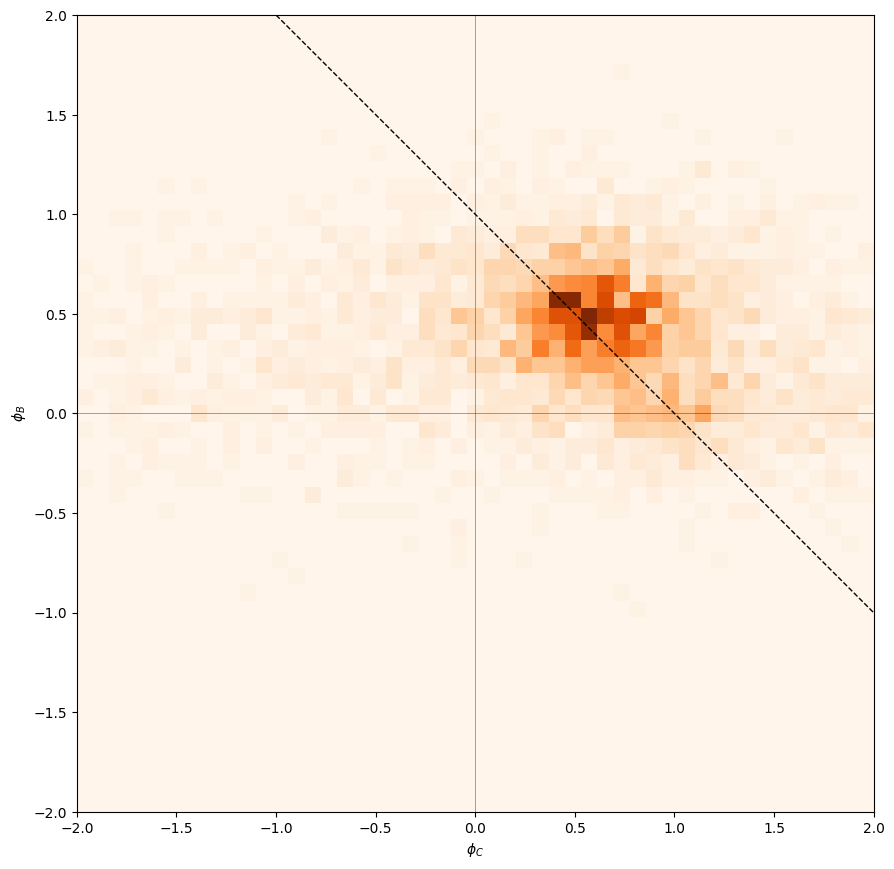

In [287]:
# Combine the histogram
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
data = []
for num, i in l.iterrows():    
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    data.append(norm_data)
combine = pd.concat(data, axis=0)
H, xedges, yedges = np.histogram2d(combine["crop-1_rb"], combine["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(H, interpolation='nearest', origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
ax.set_xlabel("$\phi_C$")
ax.set_ylabel("$\phi_B$")
plt.tight_layout()

## 5 Compare Python and ImageJ PIV

We will take 10172022/04 as an example. Eventually, all the videos on 10172022 will be analyzed for comparison. We will be comparing:

- flow field in general: by computing error for each velocity and taking average (for each component)
$$
E_v = \frac{1}{n}\sum_{i=1}^{n} \frac{| v_{\text{python}} - v_{\text{ImageJ}} |}{| v_{\text{python}}  |}
$$
- flow rate: by computing error of low rate for each image 
$$
E_Q =  \frac{| Q_{\text{python}} - Q_{\text{ImageJ}} |}{| Q_{\text{python}}  |}
$$
Then take the mean of the errors from all the images, as a metric of the difference between the two PIV methods. 

### 5.1 Create tiff stack

In [74]:
from tifffile import imwrite

In [77]:
image = np.random.rand(*(32, 256, 256))
imwrite("test.tif", image)

In [83]:
folder = r"E:\AN\10172022\channel_crops_rb"
for n in range(5, 19):
    subfolder = os.path.join(folder, "{:02d}".format(n))
    sfL = next(os.walk(subfolder))[1]    
    for sf in sfL:
        img_folder = os.path.join(subfolder, sf)
        print(img_folder)
        l = readdata(img_folder, "tif")
        img_list = []
        for num, i in l.iterrows():
            print(num, end="\r")
            img = io.imread(i.Dir)
            img_list.append(img)
        stack = np.stack(img_list, axis=0)
        imwrite(os.path.join(subfolder, "{}.tif".format(sf)), stack)

E:\AN\10172022\channel_crops_rb\05\crop-0
E:\AN\10172022\channel_crops_rb\05\crop-1
E:\AN\10172022\channel_crops_rb\05\crop-2
E:\AN\10172022\channel_crops_rb\06\crop-0
E:\AN\10172022\channel_crops_rb\06\crop-1
E:\AN\10172022\channel_crops_rb\06\crop-2
E:\AN\10172022\channel_crops_rb\07\crop-0
E:\AN\10172022\channel_crops_rb\07\crop-1
E:\AN\10172022\channel_crops_rb\07\crop-2
E:\AN\10172022\channel_crops_rb\08\crop-0
E:\AN\10172022\channel_crops_rb\08\crop-1
E:\AN\10172022\channel_crops_rb\08\crop-2
E:\AN\10172022\channel_crops_rb\09\crop-0
E:\AN\10172022\channel_crops_rb\09\crop-1
E:\AN\10172022\channel_crops_rb\09\crop-2
E:\AN\10172022\channel_crops_rb\10\crop-0
E:\AN\10172022\channel_crops_rb\10\crop-1
E:\AN\10172022\channel_crops_rb\10\crop-2
E:\AN\10172022\channel_crops_rb\11\crop-0
E:\AN\10172022\channel_crops_rb\11\crop-1
E:\AN\10172022\channel_crops_rb\11\crop-2
E:\AN\10172022\channel_crops_rb\12\crop-0
E:\AN\10172022\channel_crops_rb\12\crop-1
E:\AN\10172022\channel_crops_rb\12

### 5.2 Read PIV data from ImageJ 

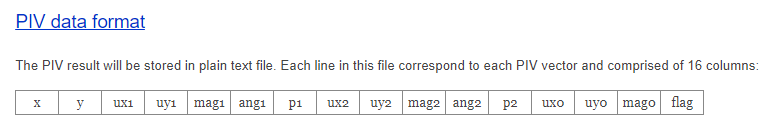

In [3]:
data_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
l = readdata(data_folder, "txt")
pivData = pd.read_csv(l.loc[0].Dir, sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])

In [4]:
img_folder = r"E:\AN\10172022\channel_crops_rb\04\crop-0"
li = readdata(img_folder, "tif")
img = io.imread(li.loc[0].Dir)

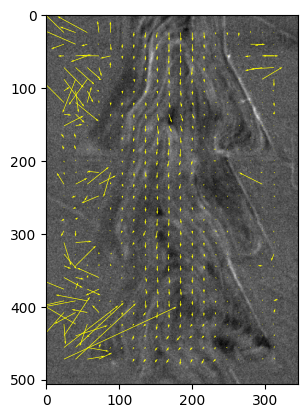

In [5]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="yellow")

Apparently, the ImageJ PIV gives opposite velocity in $y$, compared to Python PIV. Need to be careful with this difference.

### 5.3 Apply mask

In [65]:
def apply_mask(pivData, mask, erode=1):
    mask = cv2.erode(mask.astype("uint8"), np.ones((erode, erode), dtype="uint8"))
    mask = mask > mask.mean()
    ind = mask[pivData.y.astype("int"), pivData.x.astype("int")]
    p = pivData.copy() # avoid setting values to the original copy
    p.loc[~ind, ["u", "v"]] = np.nan
    return p

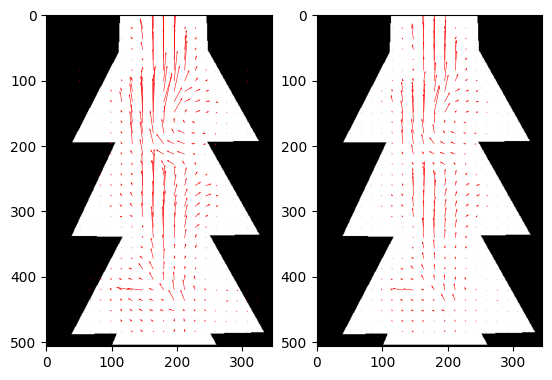

In [69]:
# test
pivData = pd.read_csv("test_files/piv-test.csv")
mask = io.imread("test_files/mask.tif")
mpiv = apply_mask(pivData, mask)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(mask, cmap="gray")
ax[0].quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="red")
ax[1].imshow(mask, cmap="gray")
ax[1].quiver(mpiv.x, mpiv.y, mpiv.u, mpiv.v, color="red")

In [2]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(4, 5):
    for sf in sfL:
        mask = io.imread(os.path.join(mask_folder, "{}.tif".format(sf)))        
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        save_folder = os.path.join(piv_folder, "{:02d}".format(n), "{}_masked".format(sf))
        if os.path.exists(save_folder) == False:
            os.makedirs(save_folder)
        for num, i in l.iterrows():
            pivData = pd.read_csv(i.Dir)
            mpiv = apply_mask(pivData, mask)
            mpiv.to_csv(os.path.join(save_folder, "{}.csv".format(i.Name)), index=False)

C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\matplotlib\quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


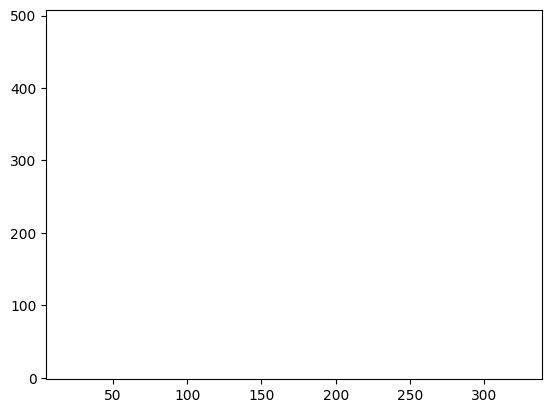

In [6]:
folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
n = 0
x, y, u, v = read_piv(os.path.join(folder, "{0:05d}-{1:05d}.csv".format(n, n+1)))
plt.quiver(x, y, u, v)

In [94]:
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool = mask >= mask.max()

My old way of applying masks requires that the PIV windows are put in the same way as my function `divide_windows`. This is not true for the ImageJ PIV. So here we seek a new way to mask PIV results. An intuitive method is to check the PIV xy's one by one, see if they are True or false in the image size mask.

In [135]:
mask_bool = mask_raw.astype("bool")[pivData.y, pivData.x]

In [114]:
pivData_masked = pivData.copy()
pivData_masked.loc[~mask_bool, "u"] = np.nan
pivData_masked.loc[~mask_bool, "v"] = np.nan

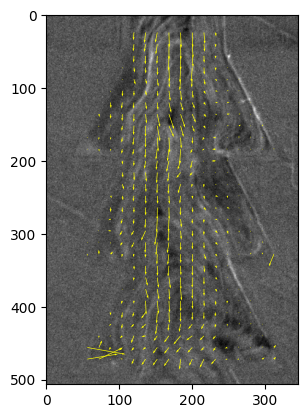

In [116]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, pivData_masked.v, color="yellow")

#### Mask near boundary regions -> shrink the mask further

In [142]:
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))

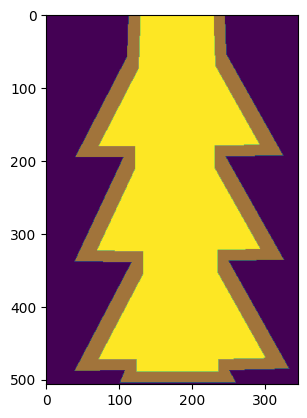

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(mask_raw)
ax.imshow(mask_shrink, alpha=0.5)

In [144]:
mask_bool = mask_shrink.astype("bool")[pivData.y, pivData.x]

In [145]:
pivData_masked = pivData.copy()
pivData_masked.loc[~mask_bool, "u"] = np.nan
pivData_masked.loc[~mask_bool, "v"] = np.nan

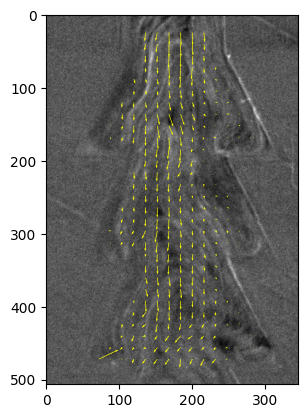

In [146]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, pivData_masked.v, color="yellow")

### 5.4 Compare with Python results

In [147]:
pypiv_folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
x, y, u, v = read_piv(os.path.join(pypiv_folder, "00000-00001.csv"))
# load mask
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool = mask >= mask.max()
# apply mask
u[~mask_bool] = np.nan
v[~mask_bool] = np.nan

(-0.5, 344.5, 506.5, -0.5)

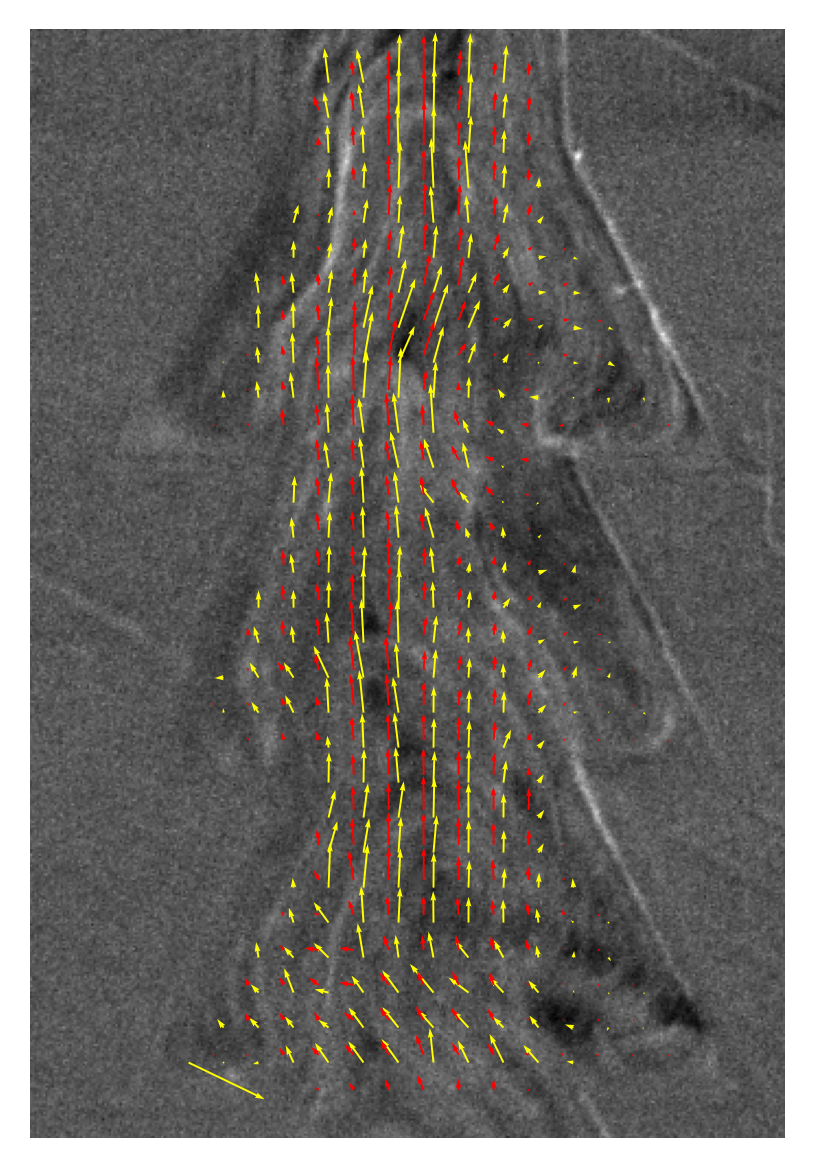

In [149]:
plt.figure(dpi=300)
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, -pivData_masked.v, color="yellow", scale=90)
plt.quiver(x, y, u, v, color="red", scale=90)
plt.axis("off")

#### Mean velocity (vertical)

In [153]:
vi = -pivData_masked.v.mean()
vp = np.nanmean(v)
e = abs(vp - vi) / vp
print(vi, vp, "error={:.2f}".format(e))

2.531077389817271 1.6504453681778235 error=0.53


This is a decent error between the mean velocities. Although the flow field look quite similar.

#### Compare a whole video

In [9]:
img_folder = r"E:\AN\10172022\channel_crops_rb\04\crop-0"
ijpiv_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
pypiv_folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"

# mask treatment
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
## py piv
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool_py = mask >= mask.max()
## ij piv
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))
pivData = pd.read_csv(os.path.join(ijpiv_folder, "_1.txt"), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
mask_bool_ij = mask_shrink.astype("bool")[pivData.y, pivData.x]

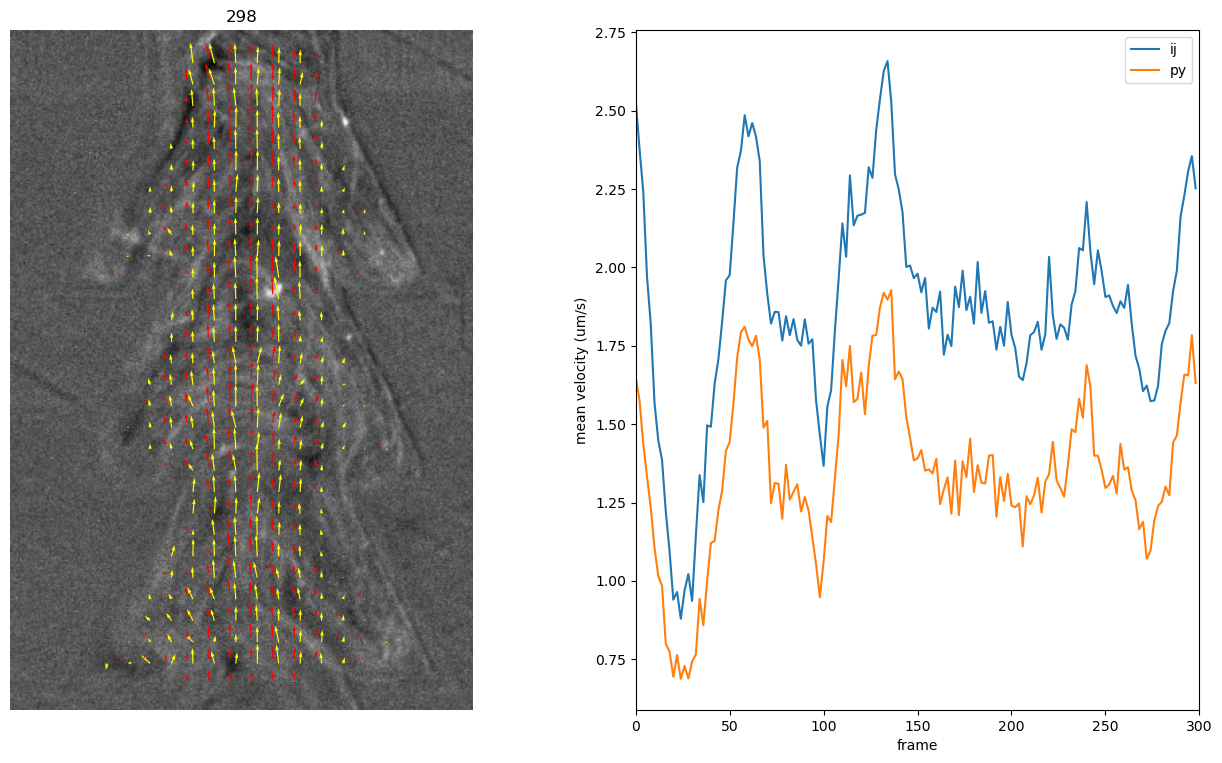

In [10]:
l = readdata(pypiv_folder, "csv")
e_list, vi_list, vp_list = [], [], []
for num, i in l.iterrows():
    # load image
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(2*num)))
    # load data
    x, y, u, v = read_piv(i.Dir)
    pivData = pd.read_csv(os.path.join(ijpiv_folder, "_{:d}.txt".format(num*2+1)), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    u[~mask_bool_py] = np.nan
    v[~mask_bool_py] = np.nan
    # compute & record error
    vi = -pivData_masked.v.mean()
    vp = np.nanmean(v)
    e = abs(vp - vi) / vp
    vi_list.append(vi)
    vp_list.append(vp)
    e_list.append(e)
    # draw
    fig, ax = plt.subplots(ncols=2, figsize=(16, 9), dpi=100)
    ax[0].set_title(2*num)
    ax[0].imshow(img, cmap="gray")
    ax[0].quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, -pivData_masked.v, color="yellow", scale=90)
    ax[0].quiver(x, y, u, v, color="red", scale=90)
    ax[0].axis("off")
    # plot mean velocity (flow rate)
    ax[1].plot(range(0, 2*num+1, 2), vi_list, label="ij")
    ax[1].plot(range(0, 2*num+1, 2), vp_list, label="py")
    ax[1].set_ylabel("mean velocity (um/s)")
    ax[1].set_xlabel("frame")
    ax[1].set_xlim([0, 300])
    # ax[1].set_ylim([1, 4])
    ax[1].legend(loc="upper right")
    # savefig
    # fig.savefig("{:05d}.jpg".format(2*num))
    plt.pause(.001)
    plt.close()
    clear_output(wait=True)

#### Compare $\phi_B$-$\phi_C$ histogram

In [223]:
fr_py

crop-0      crop-1      crop-2    t
0    284.903891  340.803741  -68.501938    0
1    232.526922  344.393668  -87.746131    2
2    230.371388  340.838579  -84.528879    4
3    213.858281  313.205306  -64.247718    6
4    214.690617  283.612907  -81.880799    8
..          ...         ...         ...  ...
145  231.543393  628.028339 -326.792325  290
146  281.044149  634.999574 -296.357216  292
147  286.334797  640.415694 -318.929774  294
148  305.288327  655.907892 -328.492531  296
149  289.310159  631.137409 -374.451380  298

[150 rows x 4 columns]

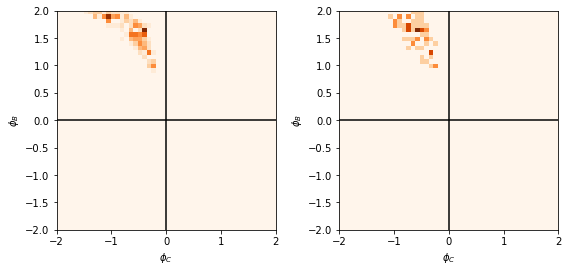

In [25]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
fr_py = pd.read_csv("test_files/flowrate/py.csv")
fr_ij[["crop-1", "crop-2"]] /= fr_ij["crop-0"].mean()
fr_py[["crop-1", "crop-2"]] /= fr_py["crop-0"].mean()

H1, xedges, yedges = np.histogram2d(fr_ij["crop-1"], fr_ij["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
H2, xedges, yedges = np.histogram2d(fr_py["crop-1"], fr_py["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(H1, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax[0].plot([-2, 2], [0, 0], color="black")
ax[0].plot([0, 0], [-2, 2], color="black")
ax[0].set_xlabel("$\phi_C$")
ax[0].set_ylabel("$\phi_B$")

ax[1].imshow(H2, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax[1].plot([-2, 2], [0, 0], color="black")
ax[1].plot([0, 0], [-2, 2], color="black")
ax[1].set_xlabel("$\phi_C$")
ax[1].set_ylabel("$\phi_B$")


plt.tight_layout()
# plt.colorbar()

#### Flow rate and normalized flow rate

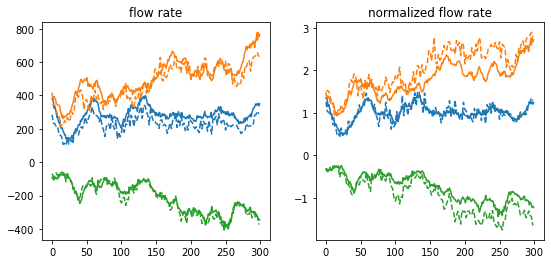

In [29]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
fr_py = pd.read_csv("test_files/flowrate/py.csv")
fr_ij_norm = fr_ij.copy()
fr_py_norm = fr_py.copy()
fr_ij_norm[["crop-0", "crop-1", "crop-2"]] /= fr_ij["crop-0"].mean()
fr_py_norm[["crop-0", "crop-1", "crop-2"]] /= fr_py["crop-0"].mean()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].set_title("flow rate")
ax[0].plot(fr_ij.t, fr_ij["crop-0"], color=bestcolor(0))
ax[0].plot(fr_py.t, fr_py["crop-0"], color=bestcolor(0), ls="--")
ax[0].plot(fr_ij.t, fr_ij["crop-1"], color=bestcolor(1))
ax[0].plot(fr_py.t, fr_py["crop-1"], color=bestcolor(1), ls="--")
ax[0].plot(fr_ij.t, fr_ij["crop-2"], color=bestcolor(2))
ax[0].plot(fr_py.t, fr_py["crop-2"], color=bestcolor(2), ls="--")

ax[1].set_title("normalized flow rate")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-0"], color=bestcolor(0))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-0"], color=bestcolor(0), ls="--")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-1"], color=bestcolor(1))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-1"], color=bestcolor(1), ls="--")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-2"], color=bestcolor(2))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-2"], color=bestcolor(2), ls="--")

#### Only for test py and ij (Not sure what this part is for)

In [21]:
piv_folder = r"E:\AN\10172022\channel_crops_rb\04"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"

In [23]:
sfL = ["PIV_crop-0", "PIV_crop-1", "PIV_crop-2"]
winsize = 32
channel_width = 150
df = pd.DataFrame()
for sf in sfL:
    subfolder = os.path.join(piv_folder, sf)
    # mask treatment
    mask_raw = io.imread(os.path.join(mask_folder, "{}.tif".format(sf.split("_")[1])))
    ## ij piv
    mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))
    pivData = pd.read_csv(os.path.join(subfolder, "_1.txt"), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    mask_bool_ij = mask_shrink.astype("bool")[pivData.y, pivData.x]
    
    l = readdata(subfolder, "txt")
    tmp = []
    for i in range(len(l)):
        pivData = pd.read_csv(os.path.join(piv_folder, sf, "_{}.txt".format(i+1)), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
        pivData.loc[~mask_bool_ij, "v"] = np.nan
        v = -pivData.v.mean()
        tmp.append(v)
    Q = np.array(tmp) * channel_width
    df[sf] = Q
df["t"] = df.index
df.to_csv(os.path.join(piv_folder, "flowrate.csv"), index=False)

### 5.5 Call ImageJ PIV function in Python

Although I personally favor the OpenPIV Python module, which is developed and maintained actively, I understand Claire that she wants the data more consistent. So here I use the ImageJ PIV method to compute velocity field. This will require a package [Py4J](https://www.py4j.org/index.html).

** Failed **

The tutorial example worked, but applying it to the PIV class turns out to be not so straightforward. I briefly document what I have tried, for future reference.

1. I copy-paste the example code "Stack" from py4j tutorial and try to compile using `java Stack.java`, only to realize that I need to install JDK, on top of JRE to compile. JDK is for developer, apparently.

2. Installed JDK, I compile again and run into issues of undefined symbol "Stack". Although I define it already in a file and compile another file which is under the same package. Then I realize that the compile should be on both files in one command, like `java Entry.java Stack.java`, or more simply, `java *.java`.

3. After successfully compiling the code, I run it using `java Entry` (the class name), and it worked correctly. 

4. Using this knowledge on iterative_PIV.java, the compiling part worked as well. But when I try to run the `Entry` class, Java raises undefinedclass error of `ij.plugin.filter.pluginfilter`. I searched about this issue but did not learn much. 

Conclusion: the Java in Python approach is not working. Use ImageJ macro to do the automation.

In [25]:
from py4j.java_gateway import *
port = launch_gateway()
gateway = JavaGateway(
gateway_parameters=GatewayParameters(port=port),
callback_server_parameters=CallbackServerParameters(port=0))
random = gateway.jvm.java.util.Random()

In [28]:
stack.push("First %s" % ('item'))

In [29]:
stack.pop()

'First item'

In [22]:
dir(PIV)

['<package or class name>']

## 6 Investigate the weird spikes in ImageJ PIV results

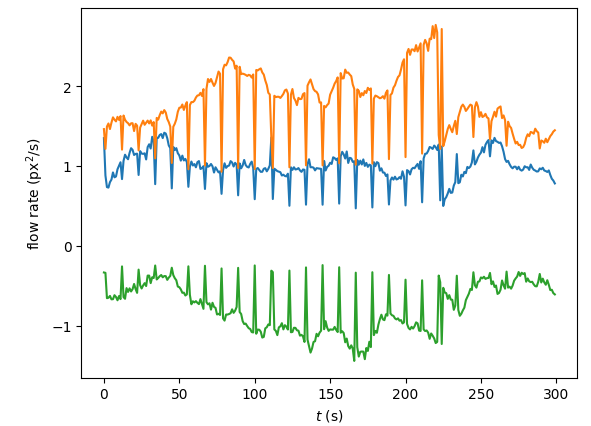

#### Where are the spikes?

We can smooth the time series data first, then select the data points that show large deviation. They are the spikes. 

In [232]:
from scipy.signal import medfilt
from myImageLib import bestcolor

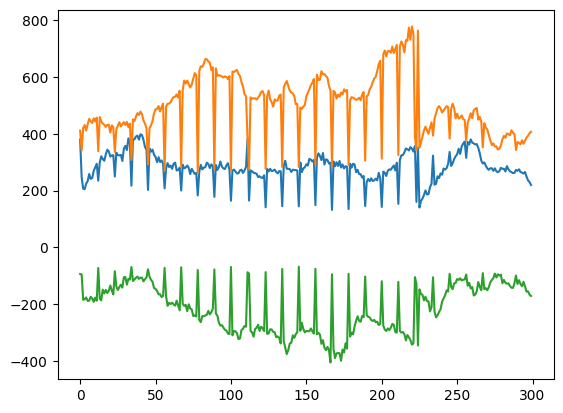

In [231]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
plt.plot(fr_ij["crop-0"])
plt.plot(fr_ij["crop-1"])
plt.plot(fr_ij["crop-2"])

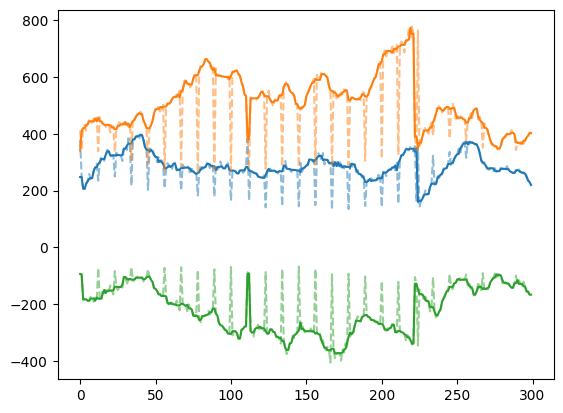

In [236]:
# plot filtered time series
plt.plot(fr_ij["crop-0"], color=bestcolor(0), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-0"],3), color=bestcolor(0))
plt.plot(fr_ij["crop-1"], color=bestcolor(1), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-1"],3), color=bestcolor(1))
plt.plot(fr_ij["crop-2"], color=bestcolor(2), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-2"],3), color=bestcolor(2))

Here, let's set the criterion as "deviation greater than the mean deviation".

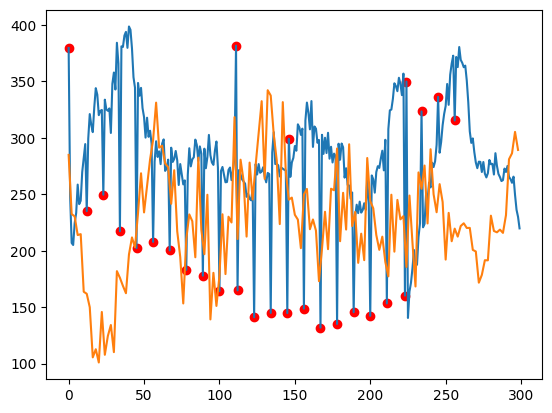

In [243]:
dev = abs(fr_ij["crop-0"] - medfilt(fr_ij["crop-0"],3))
spike_ind = dev > 2 * dev.mean()
plt.plot(fr_ij["crop-0"])
plt.plot(fr_py["t"], fr_py["crop-0"])
plt.scatter(fr_ij[spike_ind].t, fr_ij[spike_ind]["crop-0"], color="red")

In [242]:
fr_ij[spike_ind]

crop-0      crop-1      crop-2    t
0    379.661608  411.381052  -94.305390    0
12   235.092294  339.026818  -72.849853   12
23   249.645344  336.265100  -84.189558   23
34   217.254781  308.363626  -69.683214   34
45   202.286465  291.975909  -77.490032   45
56   207.834706  270.139553  -72.585367   56
67   200.278859  282.887097  -70.569054   67
78   183.046033  260.970508  -80.068760   78
89   177.871715  274.173080  -77.983058   89
100  164.181701  270.499471  -69.450926  100
111  381.703870  382.148806  -87.988720  111
112  164.826980  273.957575  -92.982952  112
123  141.004401  276.641931  -87.548171  123
134  144.876414  283.547704  -76.427029  134
145  144.690024  283.326840  -68.267890  145
146  299.177832  493.129825 -294.386812  146
156  148.674151  291.136980  -75.835009  156
167  131.865451  285.764067  -94.931475  167
178  135.064274  289.795083  -93.401284  178
189  145.482226  305.476167 -102.965126  189
200  142.266344  312.630509 -119.683143  200
211  153.263778  325.069721 -121.903034  211
223  160.169274  341.696596 -128.474252  223
224  349.910198  764.484098 -346.518083  224
234  323.402676  393.978458 -105.700710  234
245  336.287342  383.435667  -93.557411  245
256  315.400858  375.868086  -95.889246  256

### Why I did not see the spikes in the mean velocity time series?

Compute mean velocity again!

In [6]:
ijpiv_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"

# mask treatment
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
## py piv
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool_py = mask >= mask.max()
## ij piv
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))
pivData = pd.read_csv(os.path.join(ijpiv_folder, "_1.txt"), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
mask_bool_ij = mask_shrink.astype("bool")[pivData.y, pivData.x]

In [7]:
l = readdata(ijpiv_folder, "txt")
v_list = []
for num, i in l.iterrows():
    pivData = pd.read_csv(i.Dir, sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    
    v = -pivData_masked.v.mean()
    v_list.append(v)

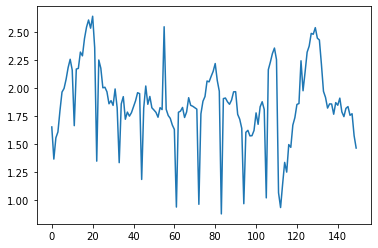

In [12]:
plt.plot(v_list[1::2])

In [17]:
l = readdata(ijpiv_folder, "txt")
c_list = []
for num, i in l.iterrows():
    c_list.append(i.Name)
print(c_list)

['_1', '_10', '_100', '_101', '_102', '_103', '_104', '_105', '_106', '_107', '_108', '_109', '_11', '_110', '_111', '_112', '_113', '_114', '_115', '_116', '_117', '_118', '_119', '_12', '_120', '_121', '_122', '_123', '_124', '_125', '_126', '_127', '_128', '_129', '_13', '_130', '_131', '_132', '_133', '_134', '_135', '_136', '_137', '_138', '_139', '_14', '_140', '_141', '_142', '_143', '_144', '_145', '_146', '_147', '_148', '_149', '_15', '_150', '_151', '_152', '_153', '_154', '_155', '_156', '_157', '_158', '_159', '_16', '_160', '_161', '_162', '_163', '_164', '_165', '_166', '_167', '_168', '_169', '_17', '_170', '_171', '_172', '_173', '_174', '_175', '_176', '_177', '_178', '_179', '_18', '_180', '_181', '_182', '_183', '_184', '_185', '_186', '_187', '_188', '_189', '_19', '_190', '_191', '_192', '_193', '_194', '_195', '_196', '_197', '_198', '_199', '_2', '_20', '_200', '_201', '_202', '_203', '_204', '_205', '_206', '_207', '_208', '_209', '_21', '_210', '_211', '_212',

I understand! The problem is from the data reading order. We want the order to be sorted by number, but in fact the software by default sort by character order. As a result, the default data read order is `['_1', '_10', '_100', '_101', '_102', '_103', '_104', '_105', '_106', '_107', '_108', '_109', '_11', '_110', '_111', '_112', '_113', '_114', '_115', '_116', '_117', '_118', '_119', '_12']`. 100-109 is consecutive, then 11 is an outlier, thus a spike. Then we have 110-119 consecutive, then 12 is an outlier. This explains why we see a spike every 11 points. 

In the previous section, we read the ij PIV data by iterating number $i$ in a range, avoiding sorting data file names. Therefore we don't see spikes there. In the following, we try to read PIV data in the right order. 

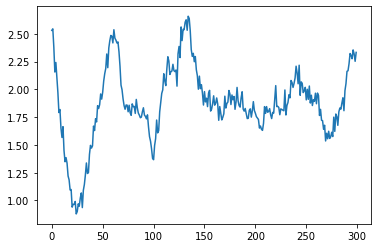

In [20]:
v_list = []
for i in range(1, 301):
    pivData = pd.read_csv(os.path.join(ijpiv_folder, "_{:d}.txt".format(i)), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    
    v = -pivData_masked.v.mean()
    v_list.append(v)
plt.plot(v_list)

In [246]:
ijpiv_folder = r"C:\Users\liuzy\Documents\10172022\04\PIV_crop-0"
l = readdata(ijpiv_folder, "txt")
l

Name                                                Dir
0      _1  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
1     _10  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
2    _100  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
3    _101  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
4    _102  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
..    ...                                                ...
295   _95  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
296   _96  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
297   _97  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
298   _98  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...
299   _99  C:\Users\liuzy\Documents\10172022\04\PIV_crop-...

[300 rows x 2 columns]

## 7 Image processing scripts

- Export tif sequences (done)
- Generate channel crops
- Remove backgrounds
- PIV
- Apply masks
- Compute flow rates

In [252]:
next(os.walk(r"C:\Users\liuzy\Documents\01172022"))[1]

['mask',
 'mean_velocity',
 'preview',
 'velocity_autocorr',
 'velocity_autocorr.old']

### A simple script to test PIV

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

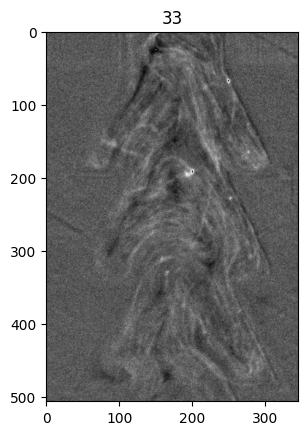

In [270]:
img_folder = r"C:\Users\liuzy\Documents\10312022\crop_channel\00\crop-0_rb"
piv_folder = r"C:\Users\liuzy\Documents\10312022\PIV\00\crop-0_rb"

l = readdata(piv_folder, "csv")
for num, i in l.iterrows():
    # img = io.imread(os.path.join(img_folder, "{}.tif".format(i.Name.split("-")[0])))
    x, y, u, v = read_piv(i.Dir)
    plt.title(num)
    plt.imshow(img, cmap="gray")
    plt.quiver(x, y, u, v, color="yellow")
    plt.pause(.1)
    plt.close()
    clear_output(wait=True)

### 7.1 Some quick check scripts

- Check crops: generate a figure with all the crops of the first image. (need to download the image from server to check by eye)

In [272]:
np.arctan(20/2000) / 2 / np.pi * 360

0.5729386976834859

## 8 Temperature activity

In [3]:
data = pd.read_csv(r"../Data/temperature-activity.csv")

Text(0, 0.5, 'Flow rate in channels (px$^2$/s)')

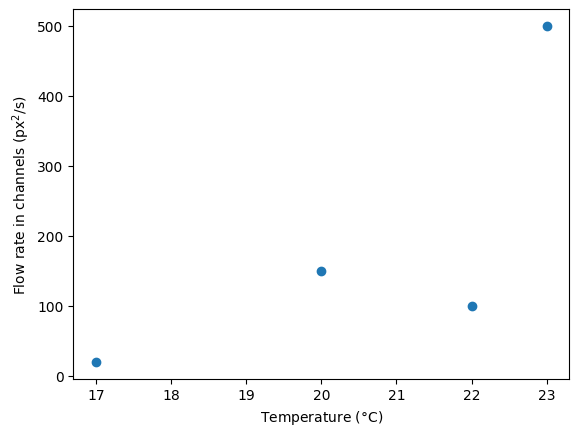

In [9]:
plt.scatter(data["Temperature"], data["Flow rate"])
plt.xlabel("Temperature ($\\degree$C)")
plt.ylabel("Flow rate in channels (px$^2$/s)")

In [1]:
# test apply_mask
from pivLib import apply_mask, PIV, PIV1
from skimage import io

In [2]:
help(apply_mask)

Help on function apply_mask in module pivLib:

apply_mask(pivData, mask, erode=1)
    Apply a mask on PIV data, by replacing all the masked velocity as ``np.nan``.
    
    :param pivData: PIV data (x, y, u, v)
    :type pivData: pandas.DataFrame
    :param mask: an image, preferrably binary, where large value denotes valid data and small value denote invalid data. The image will be converted to a boolean array by ``mask = mask > mask.mean()``.
    :type mask: 2D array
    :param erode: sometimes, we want to exclude more boundary data, to make sure we don't have artifacts from boundary. ``erode`` makes this possible by applying a erode morphological transformation to the boolean mask, effectively reduces the True region (by half of the erode size). Default to 1, which does not modify the mask.
    
    .. note::
    
       ``erode`` is used to generate an erode kernel ``np.ones((erode, erode))``, if ``erode=0``, no kernel will be generated and the function will then use a default kern

In [3]:
pivData = pd.read_csv("E:/AN/10172022/channel_piv_rb/04/crop-0/00000-00001.csv")
mask = io.imread("E:/AN/10172022/channel_crops/04/masks/crop-0.tif")

NameError: name 'pd' is not defined

In [5]:
I0 = io.imread(r"E:\AN\10172022\channel_crops_rb\04\crop-0\00000.tif")
I1 = io.imread(r"E:\AN\10172022\channel_crops_rb\04\crop-0\00001.tif")

In [16]:
from openpiv import pyprocess, validation
import numpy as np

In [19]:
a = pyprocess.extended_search_area_piv(I0.astype(np.int32), I1.astype(np.int32), 32, overlap=16)

In [12]:
winsize = 32
overlap = 16
dt = 1

In [25]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        I0.astype(np.int32),
        I1.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=winsize,
        sig2noise_method='peak2peak',
    )

In [42]:
u1, v1, mask_s2n = validation.sig2noise_val(
        u0, v0,
        sig2noise,
        threshold = 1)

In [43]:
u1

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [39]:
sig2noise < 1

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True],
       [Fa

In [38]:
validation.sig2noise_val(
        u0, v0,
        sig2noise,
        threshold = 0)

(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan,

In [8]:
PIV(I0, I1, 32, 16, 1)

(array([[ 20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164., 180.,
         196., 212., 228., 244., 260., 276., 292., 308., 324.],
        [ 20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164., 180.,
         196., 212., 228., 244., 260., 276., 292., 308., 324.],
        [ 20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164., 180.,
         196., 212., 228., 244., 260., 276., 292., 308., 324.],
        [ 20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164., 180.,
         196., 212., 228., 244., 260., 276., 292., 308., 324.],
        [ 20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164., 180.,
         196., 212., 228., 244., 260., 276., 292., 308., 324.],
        [ 20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164., 180.,
         196., 212., 228., 244., 260., 276., 292., 308., 324.],
        [ 20.,  36.,  52.,  68.,  84., 100., 116., 132., 148., 164., 180.,
         196., 212., 228., 244., 260., 276., 292., 308., 324.],
        [ 20.,  36.,  52., 

In [10]:
PIV1(I0, I1, 32, 16, 1, smooth=False)

ValueError: too many values to unpack (expected 2)

In [50]:
u

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [43]:
mp = apply_mask(pivData, mask)

C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\matplotlib\quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


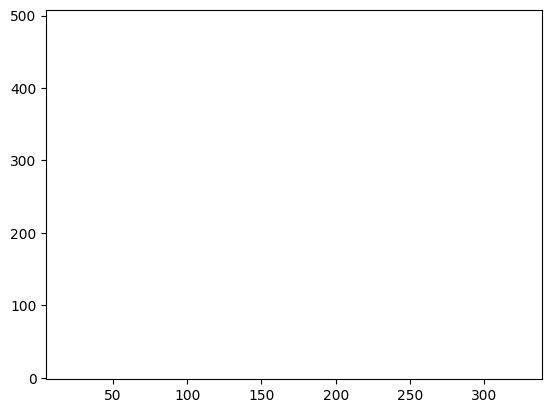

In [44]:
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v)

In [45]:
pivData

x      y   u   v
0     20.0   21.0 NaN NaN
1     36.0   21.0 NaN NaN
2     52.0   21.0 NaN NaN
3     68.0   21.0 NaN NaN
4     84.0   21.0 NaN NaN
..     ...    ...  ..  ..
595  260.0  485.0 NaN NaN
596  276.0  485.0 NaN NaN
597  292.0  485.0 NaN NaN
598  308.0  485.0 NaN NaN
599  324.0  485.0 NaN NaN

[600 rows x 4 columns]

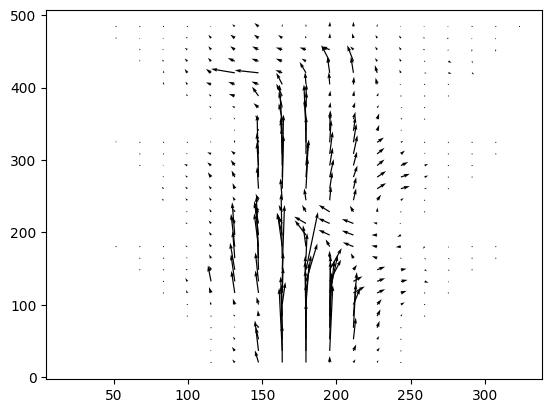

In [37]:
plt.quiver(mp.x, mp.y, mp.u, mp.v)